In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os, time, stat, io
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2
from covid_data_helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Notes
- Questions
    - How will we know if the lock down is working? early signals from acceleration in hospitalization
    
- Things to do with cohort model:
    - Compliance levels
    - Monte carlo
    - vary hospital duration by icu/non-icu
    - vary asymptomatic transmission vs symptomatic
    - Add recovered line
    - functionalize charts
    - Functionalize the mortality rate by hospital capacity.

# Data Ingestion

## Bring in NYS Region Data

In [141]:
df_nys_region = get_nys_region()
df_nys_region.head()

metric                  3-Day Rolling Avg Net New Hospitalizations  \
ny_region   dt                                                       
Long Island 2020-03-15                                         NaN   
            2020-03-16                                         NaN   
            2020-03-17                                         NaN   
            2020-03-18                                         NaN   
            2020-03-19                                         NaN   

metric                  3-Day Rolling Avg of Change in Net New Hospitalizations  \
ny_region   dt                                                                    
Long Island 2020-03-15                                                NaN         
            2020-03-16                                                NaN         
            2020-03-17                                                NaN         
            2020-03-18                                                NaN         
            2020-03-19                                                NaN         

metric                  Change in Net New Hospitalizations  \
ny_region   dt                                               
Long Island 2020-03-15                                 NaN   
            2020-03-16                                 NaN   
            2020-03-17                                 NaN   
            2020-03-18                                 NaN   
            2020-03-19                                 NaN   

metric                  Concurrent Hospitalizations  Net New Hospitalizations  \
ny_region   dt                                                                  
Long Island 2020-03-15                         26.0                       NaN   
            2020-03-16                         56.0                       NaN   
            2020-03-17                         93.0                       NaN   
            2020-03-18                        132.0                       NaN   
            2020-03-19                        201.0                       NaN   

metric                  Projection of 3-Day Rolling Avg of Change in Net New Hospitalizations  \
ny_region   dt                                                                                  
Long Island 2020-03-15                                                NaN                       
            2020-03-16                                                NaN                       
            2020-03-17                                                NaN                       
            2020-03-18                                                NaN                       
            2020-03-19                                                NaN                       

metric                  Projection of Concurrent Hospitalizations  \
ny_region   dt                                                      
Long Island 2020-03-15                                       26.0   
            2020-03-16                                       56.0   
            2020-03-17                                       93.0   
            2020-03-18                                      132.0   
            2020-03-19                                      201.0   

metric                  Projection of Net New Hospitalizations  \
ny_region   dt                                                   
Long Island 2020-03-15                                     NaN   
            2020-03-16                                     NaN   
            2020-03-17                                     NaN   
            2020-03-18                                     NaN   
            2020-03-19                                     NaN   

metric                  Projection of Share of Hospitalizations  \
ny_region   dt                                                    
Long Island 2020-03-15                                     17.0   
            2020-03-16                                     17.0   
            2020-03-17       

## Bring in county reporting data

In [142]:
df_reporting = get_nyt_counties()
df_reporting.reorder_levels([1,2,0]).loc[['New York']].tail()

date     fips  cases  deaths
state    county      dt                                            
New York Washington  2020-04-11  2020-04-11  36115.0     31       0
         Wayne       2020-04-11  2020-04-11  36117.0     42       0
         Westchester 2020-04-11  2020-04-11  36119.0  18729     505
         Wyoming     2020-04-11  2020-04-11  36121.0     31       0
         Yates       2020-04-11  2020-04-11  36123.0      2       0

In [143]:
df_reporting_fmt = reporting_by_nys_region()
df_reporting_fmt.tail()

cases                                                        \
           Long Island      NYC Westchester & Rockland Rest of NYS       NYS   
dt                                                                             
2020-04-07     32171.0  76876.0                20794.0     10240.0  140081.0   
2020-04-08     34392.0  81803.0                22300.0     10906.0  149401.0   
2020-04-09     37553.0  87028.0                23669.0     11687.0  159937.0   
2020-04-10     40204.0  92384.0                25199.0     12725.0  170512.0   
2020-04-11     42467.0  98308.0                26206.0     13477.0  180458.0   

                deaths                                                     
           Long Island     NYC Westchester & Rockland Rest of NYS     NYS  
dt                                                                         
2020-04-07       886.0  4009.0                  423.0       245.0  5563.0  
2020-04-08      1029.0  4571.0                  441.0       227.0  6268.0  
2020-04-09      1147.0  5150.0                  506.0       264.0  7067.0  
2020-04-10      1315.0  5663.0                  563.0       303.0  7844.0  
2020-04-11      1434.0  6202.0                  658.0       333.0  8627.0

## Bring in Google Data

In [144]:
df_goog = pd.read_pickle('./data/df_counties_20200329.pkl')
df_goog.head()


category                           grocery/pharmacy  parks  residential  \
state   county         date                                               
Alabama Autauga County 2020-02-16             0.795    NaN          NaN   
                       2020-02-17            -0.398    NaN          NaN   
                       2020-02-18             0.401    NaN          NaN   
                       2020-02-19            -0.402    NaN          NaN   
                       2020-02-20            -2.871    NaN          NaN   

category                           retail/recreation  transitstations  \
state   county         date                                             
Alabama Autauga County 2020-02-16              0.179              NaN   
                       2020-02-17              8.054              NaN   
                       2020-02-18             -1.745              NaN   
                       2020-02-19             -1.733              NaN   
                       2020-02-20             -8.061              NaN   

category                           workplace  
state   county         date                   
Alabama Autauga County 2020-02-16     -4.223  
                       2020-02-17    -28.153  
                       2020-02-18      1.890  
                       2020-02-19      1.868  
                       2020-02-20      1.248

In [145]:
df_goog.loc['New York'].unstack(0)['transitstations'].columns

Index(['Albany County', 'Allegany County', 'Bronx County', 'Broome County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
       'Delaware County', 'Dutchess County', 'Erie County', 'Essex County',
       'Franklin County', 'Fulton County', 'Genesee County', 'Greene County',
       'Herkimer County', 'Jefferson County', 'Livingston County',
       'Madison County', 'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County', 'Onondaga County',
       'Ontario County', 'Orange County', 'Orleans County', 'Oswego County',
       'Otsego County', 'Rensselaer County', 'Richmond County',
       'Rockland County', 'Saratoga County', 'Schenectady County',
       'Schoharie County', 'St. Lawrence County', 'Steuben County',
       'Ulster County', 'Warren County', 'Westchester County',
       'Wyoming County', 'Yates County'],
      dtype='object', name='county

## Bring in State Data

In [146]:
df_st_testing = get_covid19_tracking_data()
df_st_testing.loc[['NY']].tail()

State Testing Data Last Observation:  20200412


date  positive  negative  pending  hospitalizedCurrently  \
code dt                                                                         
NY   2020-04-08  20200408  149316.0  215837.0      NaN                18079.0   
     2020-04-09  20200409  159937.0  231612.0      NaN                18279.0   
     2020-04-10  20200410  170512.0  247373.0      NaN                18569.0   
     2020-04-11  20200411  180458.0  260522.0      NaN                18654.0   
     2020-04-12  20200412  188694.0  272907.0      NaN                18707.0   

                 hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
code dt                                                                    
NY   2020-04-08                 34432.0          4593.0              NaN   
     2020-04-09                 36576.0          4925.0              NaN   
     2020-04-10                 38818.0          4908.0              NaN   
     2020-04-11                 40679.0          5009.0              NaN   
     2020-04-12                 42594.0          5198.0              NaN   

                 onVentilatorCurrently  onVentilatorCumulative  ...  \
code dt                                                         ...   
NY   2020-04-08                    NaN                     NaN  ...   
     2020-04-09                    NaN                     NaN  ...   
     2020-04-10                    NaN                     NaN  ...   
     2020-04-11                    NaN                     NaN  ...   
     2020-04-12                    NaN                     NaN  ...   

                 hospitalized     total totalTestResults    posNeg  fips  \
code dt                                                                    
NY   2020-04-08       34432.0  365153.0         365153.0  365153.0    36   
     2020-04-09       36576.0  391549.0         391549.0  391549.0    36   
     2020-04-10       38818.0  417885.0         417885.0  417885.0    36   
     2020-04-11       40679.0  440980.0         440980.0  440980.0    36   
     2020-04-12       42594.0  461601.0         461601.0  461601.0    36   

                 deathIncrease  hospitalizedIncrease  negativeIncrease  \
code dt                                                                  
NY   2020-04-08          779.0                2349.0           14642.0   
     2020-04-09          799.0                2144.0           15775.0   
     2020-04-10          777.0                2242.0           15761.0   
     2020-04-11          783.0                1861.0           13149.0   
     2020-04-12          758.0                1915.0           12385.0   

                 positiveIncrease  totalTestResultsIncrease  
code dt                                                      
NY   2020-04-08           10453.0                   25095.0  
     2020-04-09           10621.0                   26396.0  
     2020-04-10           10575.0                   26336.0  
     2020-04-11            9946.0                   23095.0  
     2020-04-12            8236.0                   20621.0  

[5 rows x 24 columns]

## Bring in NYC DOH Data

In [33]:
df_nycdoh = get_nycdoh_data()
df_nycdoh.tail()

DATE_OF_INTEREST  NEW_COVID_CASE_COUNT  HOSPITALIZED_CASE_COUNT  \
dt                                                                           
2020-04-08           4/8/20                  4049                    957.0   
2020-04-09           4/9/20                  3099                    352.0   
2020-04-10          4/10/20                  2390                    117.0   
2020-04-11          4/11/20                   741                      5.0   
2020-04-12          4/12/20                    92                      NaN   

            DEATH_COUNT  
dt                       
2020-04-08        396.0  
2020-04-09        340.0  
2020-04-10        295.0  
2020-04-11        191.0  
2020-04-12         29.0

## Estimate NYC Simultaneous Hospitalization Data

In [34]:
df_st_testing.loc['NY',('hospitalizedCurrently')].tail()

dt
2020-04-08    18079.0
2020-04-09    18279.0
2020-04-10    18569.0
2020-04-11    18654.0
2020-04-12    18707.0
Name: hospitalizedCurrently, dtype: float64

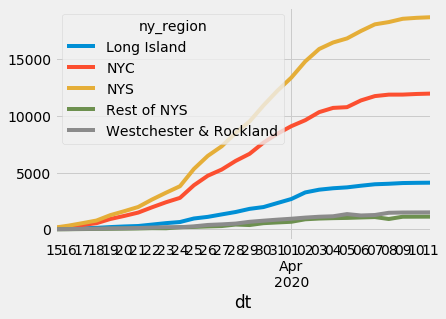

In [35]:
df_hosps = df_nys_region['Concurrent Hospitalizations'].unstack(0).dropna(how='all')
df_hosps.plot()

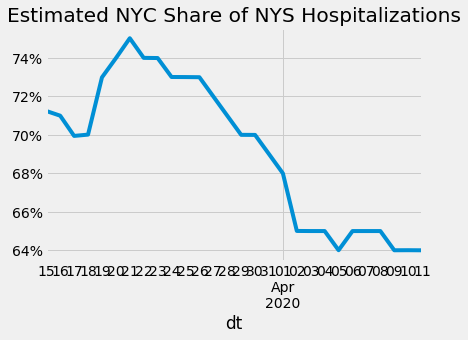

In [36]:
ax = df_hosps['NYC'].div(df_hosps.NYS).plot(title='Estimated NYC Share of NYS Hospitalizations')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))


In [136]:
df_census = get_census_pop()
df_census.head()

state   county   fips  SUMLEV  REGION  DIVISION  pop2019
0  Alabama  Alabama  01000      40       3         6  4903185
1  Alabama  Autauga  01001      50       3         6    55869
2  Alabama  Baldwin  01003      50       3         6   223234
3  Alabama  Barbour  01005      50       3         6    24686
4  Alabama     Bibb  01007      50       3         6    22394

In [161]:
s_nypop = {}
s_nypop['NYS'] = df_census[(df_census.state=="New York")
         & (df_census.SUMLEV==40)]['pop2019'].sum()

nys_regions_map = get_nyregionmap()
nys_regions_map['NYC'] = ['Bronx','Kings','New York','Queens','Richmond']

for region, counties in nys_regions_map.items():
    s_nypop[region] = df_census[(df_census.state=="New York")
         & (df_census.county.isin(nys_regions_map[region]))
         & (df_census.SUMLEV==50)]['pop2019'].sum()

s_nypop = pd.Series(s_nypop)
s_nypop


NYS                       19453561
Long Island                2833525
NYC                        8336817
Westchester & Rockland     1293295
Rest of NYS                6989924
dtype: int64

# Model Functions

In [37]:
def seir_model(suspop_0, exposed_0, infectious_0, recovered_0, deaths_0, last_obs_dt, 
               r0, d_incub, d_infect, 
               t):

    suspop, exposed, infectious, resolved = [suspop_0], [exposed_0], [infectious_0], [recovered_0 + deaths_0]
    alpha = 1 / d_incub
    beta = r0 / d_infect
    gamma = 1 / d_infect
    totpop = suspop_0 + exposed_0 + infectious_0 + recovered_0 + deaths_0
    
    for t_ in t[:-1]:
        dS_dt = -1 * min(beta * suspop[-1] * infectious[-1] / totpop, suspop[-1]) 
        dE_dt = (dS_dt * -1) - (alpha * exposed[-1])
        dI_dt = (alpha * exposed[-1]) - (gamma * infectious[-1])
        dR_dt = (gamma * infectious[-1])
        
        next_suspop = suspop[-1] + dS_dt
        next_exposed = exposed[-1] + dE_dt
        next_infectious = infectious[-1] + dI_dt
        next_resolved = resolved[-1] + dR_dt
        
        suspop.append(next_suspop)
        exposed.append(next_exposed)
        infectious.append(next_infectious)
        resolved.append(next_resolved)
        
    df_out = pd.DataFrame(np.stack([suspop, exposed, infectious, resolved]).T,
                         index = pd.date_range(last_obs_dt, 
                                               last_obs_dt + pd.Timedelta(days=t.shape[0]-1)),
                         columns = ['suspop', 'exposed', 'infectious', 'resolved'])
        
    return df_out


In [38]:
def param_str_maker(d_incub, d_infect, d_to_hosp, d_in_hosp, d_til_death,
                    hosp_rt, icu_rt, vent_rt, mort_rt, basic_r0):
    
    param_dict = {'d_incub':(d_incub,'{:.1f}'), 
                  'd_infect':(d_infect,'{:.1f}'), 
                  'd_to_hosp':(d_to_hosp,'{:.1f}'), 
                  'd_in_hosp':(d_in_hosp,'{:.1f}'), 
                  'd_til_death':(d_til_death,'{:.1f}'),
                  'hosp_rt':(hosp_rt,'{:.2%}'), 
                  'icu_rt':(icu_rt,'{:.2%}'), 
                  'vent_rt':(vent_rt,'{:.2%}'), 
                  'mort_rt':(mort_rt,'{:.2%}'), 
                  'basic_r0':(basic_r0,'{:.1f}')}
    param_fmtd_dict = {}

    for param_name, param_tup in param_dict.items():
        param_val, param_fmt = param_tup
        if type(param_val) == tuple:
            param_fmtd_dict[param_name] = (param_fmt+' - '+param_fmt).format(*param_val)
        else:
            param_fmtd_dict[param_name] = param_fmt.format(param_val)
        

    param_str = '\n'.join(('Parameters Used',
                           r'$D_{{incubation}}: {}$'.format(param_fmtd_dict['d_incub'], ),
                           r'$D_{{infectious}}: {}$'.format(param_fmtd_dict['d_infect'], ),
                           r'$D_{{to hospital}}: {}$'.format(param_fmtd_dict['d_to_hosp'], ),
                           r'$D_{{in hospital}}: {}$'.format(param_fmtd_dict['d_in_hosp'], ),
                           r'$D_{{til death}}: {}$'.format(param_fmtd_dict['d_til_death'], ),
                           r'$Rate_{{Hospitalization}}: {}$'.format(param_fmtd_dict['hosp_rt'], )+'%',
                           r'$Rate_{{ICU}}: {}$'.format(param_fmtd_dict['icu_rt'], )+'%',
                           r'$Rate_{{Ventilator}}: {}$'.format(param_fmtd_dict['vent_rt'], )+'%',
                           r'$Rate_{{Mortality}}: {}$'.format(param_fmtd_dict['mort_rt'], )+'%',
                           r'$Basic R_{{0}}: {}$'.format(param_fmtd_dict['basic_r0'], )
                          ))
    return param_str

In [39]:
def ch_exposed_infectious(df_agg, r_t, region_name, param_str, chart_title=""):
    plt.style.use('fivethirtyeight')
    df_chart = df_agg[['exposed','infectious']]
#     df_chart = df_chart.iloc[8:]

    ax = df_chart.plot.area(figsize=[14,8], title=chart_title, legend=True,
                           color=['#e5ae38','#fc4f30'])
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    plt.legend(['Exposed Population','Infectious Population'],
               loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax2 = ax.twinx()
    r_t[:df_chart.index[-1]].plot(ax=ax2, color='black', linewidth=2, linestyle='--', 
                       label='Reproduction Factor (r0) - Right Axis', legend=True)
    plt.legend(loc="lower right")
    ax.set_ylim([0, ax.axes.get_yticks().max()])
    ax.set_yticks(np.linspace(0,ax.axes.get_yticks().max(),5))
    ax2.set_ylim([0, ax2.axes.get_yticks().max()])
    ax2.set_yticks(np.linspace(0,ax2.axes.get_yticks().max(),5))
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()

In [40]:
def ch_cumul_infections(df_agg, df_reporting_fmt, region_name, param_str, chart_title=""):
    plt.style.use('fivethirtyeight')
    df_chart = df_agg[['exposed', 'infectious', 'recovered', 'hospitalized', 'deaths']].sum(axis=1)
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot(figsize=[14,8], title=chart_title, legend=True, 
                       label='Forecast Cumulative Infections')
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    if region_name in df_reporting_fmt['cases'].columns:
        df_reporting_fmt['cases'][region_name].loc['2020-03-01':].plot(
            ax=ax, linestyle=':', legend=True, color=['#008fd5'],
        label='Reported Cumulative Infections')
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()
    

In [41]:
def ch_hosp(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title=""):
    df_chart = df_agg[['hospitalized','icu','vent','deaths']]
#     df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot(figsize=[14,8], title=chart_title)
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    if region_name in df_hosps.columns:
        df_hosps[region_name].plot(ax=ax, linestyle=':', legend=True,
                                   label='Observed {} Hospitalizations'.format(region_name))
    if region_name in df_reporting_fmt['deaths'].columns:
        df_reporting_fmt['deaths'][region_name].loc[
            df_hosps.index[0]:].plot(ax=ax, linestyle='-.', legend=True,
                                   label='deaths {} Cumulative Cases'.format(region_name))
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()

In [117]:
def ch_population_share(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title=""):
    df_chart = df_agg[['susceptible','deaths','exposed','hospitalized','infectious','recovered']]
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot.area(
        figsize=[14,8], title=chart_title)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax2 = ax.twinx()
    pd.Series(1.0, index=df_chart.index).plot(ax=ax2, color='black', linewidth=0, linestyle='--', legend=False)

    ax.set_ylim([0, df_chart.sum(axis=1).max()])
    ax.set_yticks(np.linspace(0,df_chart.sum(axis=1).max(),5))
    ax.set_ylabel('Population')
    ax2.set_ylim([0, 1.0])
    ax2.set_yticks(np.linspace(0,1.0,5))
    ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
    
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()
    

In [119]:
def ch_doubling_rt(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title=""):
    ## DOUBLING RATE CHART
    df_chart = np.log(2)/df_agg[['hospitalized','deaths']].pct_change()
#     df_chart = df_chart.loc[hosp_obs_dt:]
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot(figsize=[14,8], title='Forecast Doubling Rate: '+chart_title,
                      color=['#008fd5','#e5ae38'])
    if region_name in df_hosps.columns:
        hosp_dr = np.log(2)/df_hosps[region_name].pct_change().rolling(3).mean()
        hosp_dr.plot(ax=ax, linestyle=':', legend=True, color=['#008fd5'],
                     label='Observed {} Hospitalizations'.format(region_name))
    if region_name in df_reporting_fmt['deaths'].columns:
        deaths_dr = np.log(2)/df_reporting_fmt['deaths'][region_name].pct_change().rolling(3)\
            .mean().loc[hosp_dr.index[0]:]
        deaths_dr.plot(ax=ax, linestyle='-.', legend=True, color=['#e5ae38'],
                       label='Deaths {} Cumulative Cases'.format(region_name))
    plt.yscale('log')
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()
    

In [120]:
def daily_cohort_model(cohort_strt, d_to_fore, 
                       d_incub, d_infect,
                       mort_rt, d_in_hosp, hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                       icu_rt, d_in_icu, vent_rt,
                       E_0, I_0=0., H_0=0., ICU_0=0., R_0=0., D_0=0.
                      ):
    
    t = np.linspace(0, int(d_to_fore)-1, int(d_to_fore))

    E = [E_0]
    I = [I_0]
    H = [H_0]
    ICU = [ICU_0]
    R = [R_0]
    D = [D_0]
    
    for t_ in t[:-1]:
        
        #### PROBABILITY DISTRIBUTIONS FOR FLOWS ####
        prob_dI_t = gamma.pdf(t_,d_incub)

        prob_mild_dR_t = (1 - hosp_rt) * gamma.pdf(t_, d_infect+d_incub)

        prob_H_inflow_fromE0_t = hosp_rt * gamma.pdf(t_, d_to_hosp+d_incub)
        prob_H_inflow_fromI0_t = hosp_rt * gamma.pdf(t_, d_to_hosp/2, scale=2)


        prob_sev_dR_t = (hosp_rt - mort_rt) * gamma.pdf(t_, (d_in_hosp+d_to_hosp)/2, scale=2, 
                                            loc=d_incub)

        prob_dD_t = mort_rt * gamma.pdf(t_, d_til_death/1, scale=1, loc=d_incub)
        #############################################
        

        ############## FLOW ACCOUNTING ##############
        # Change in Exposed Population
        dE = -1 * min(prob_dI_t * E_0, E[-1])
        
        # Hospital Outflows, limited to be no more than hospital capacity
        d_hosp_outflow = -1 * min((prob_sev_dR_t * (E_0+I_0) 
                                   + H_0 * (prob_sev_dR_t / (hosp_rt - mort_rt)) * (1-mort_rt/hosp_rt))
                                + (prob_dD_t * (E_0+I_0) 
                                   + H_0 * (prob_dD_t / mort_rt) * mort_rt/hosp_rt ), 
                                  H[-1])
        
        if (prob_sev_dR_t + prob_dD_t) > 0:
            # Severe Recoveries - Component of Hospital Outflows
            d_sevR = (-1 * prob_sev_dR_t * d_hosp_outflow) / (prob_sev_dR_t + prob_dD_t)

            # Deaths - Component of Hospital Outflows
            dD = (-1 * prob_dD_t * d_hosp_outflow) / (prob_sev_dR_t + prob_dD_t)
        else:
            # Severe Recoveries - Component of Hospital Outflows
            d_sevR = 0.
            # Deaths - Component of Hospital Outflows
            dD = 0.
        
        # New Hospital Admittances
#         d_hosp_admits = ((prob_H_inflow_t * (E_0+I_0)))
#                          + (hosp_rt * I_0 * ((1-1/d_to_hosp)**(t_-1) - (1-1/d_to_hosp)**t_)))
        d_hosp_admits = prob_H_inflow_fromE0_t * E_0 + prob_H_inflow_fromI0_t * I_0
        
        # Infectious Inflows
        dI_inflow = -1 * dE
        
        # Mild Recoveries
        d_mildR = min(prob_mild_dR_t * (E_0+I_0), I[-1] + dI_inflow - d_hosp_admits)
        
        # Change in Recovered Population
        dR = d_mildR + d_sevR
        
        # Change in Hospitalized Population
        dH = d_hosp_admits + d_hosp_outflow
        
        # Infectious Outflows
        dI_outflow = d_mildR + d_hosp_admits
        
        # Net change in Infectious Population
        dI = dI_inflow - dI_outflow
        
        if round(dI_inflow - dI_outflow) < round(-1 * I[-1]):
            print('dI_inflow',dI_inflow)
            print('dI_outflow',dI_outflow)
            print('round(dI_inflow - dI_outflow)',round(dI_inflow - dI_outflow))
            print('I[-1]',I[-1])
            raise Exception(cohort_strt, 'Daily Cohort Infectious Net Outflows are greater than Infectious Population') 
        #############################################

        E.append(E[-1] + dE)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)
        H.append(H[-1] + dH)
        D.append(D[-1] + dD)
    df_out = pd.DataFrame(np.stack([E, I, R, H, D]).T, 
                          columns = ['exposed', 'infectious', 'recovered', 'hospitalized', 'deaths'],
                          index = pd.date_range(cohort_strt, 
                                                cohort_strt + pd.Timedelta(days=d_to_fore-1)))
    df_out['icu'] = df_out['hospitalized'].mul(icu_rt)
    df_out['vent'] = df_out['hospitalized'].mul(icu_rt*vent_rt)
    df_out.index = pd.DatetimeIndex(df_out.index).normalize()
    df_out.index.name = 'dt'
    df_out.columns.name = 'metric'
    
    return df_out


In [121]:
def seir_model_cohort(suspop_0, exposed_0, infectious_0, hospitalized_0, recovered_0, deaths_0, 
                      hosp_obs_dt, r_t, d_incub, d_infect, d_to_forecast, 
                      mort_rt, d_in_hosp, hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                      icu_rt, d_in_icu, vent_rt
                     ):

    d_to_forecast = int(d_to_forecast)
    int_displace = int(d_incub+d_to_hosp)
    suspop = [suspop_0]
    next_infectious  = infectious_0
    _gamma = 1 / d_infect
    totpop = suspop_0 + exposed_0 + infectious_0 + hospitalized_0 + recovered_0 + deaths_0
    
    t = np.linspace(0, d_to_forecast+int_displace, 
                    d_to_forecast+int_displace+1)
    
    df_all_cohorts = pd.DataFrame()
    df_all_cohorts.columns.name = 'cohort_dt'
    last_r = r_t[0]
    
    for t_ in t[:-1]:
        this_r = r_t[int(t_)]
        
        beta = this_r * _gamma
        cohort_strt = hosp_obs_dt + pd.Timedelta(days=t_-int_displace)
        d_to_fore = t[-1] - t_ + 1
        
        if this_r != last_r:
            last_r = this_r

        if t_ == 0:
            dS = 0
            
            df_daily_cohort = daily_cohort_model(
                cohort_strt, d_to_fore, 
                d_incub, d_infect, mort_rt, d_in_hosp, 
                hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                icu_rt, d_in_icu, vent_rt,
                E_0=exposed_0, I_0=infectious_0, H_0=hospitalized_0, 
                ICU_0=0., 
                R_0=recovered_0, D_0=deaths_0
            )

            df_all_cohorts[cohort_strt] = df_daily_cohort.stack()
            
            df_daily_cohort_scalar = daily_cohort_model(
                cohort_strt, d_to_fore, 
                d_incub, d_infect, mort_rt, d_in_hosp, 
                hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                icu_rt, d_in_icu, vent_rt,
                1e6
            ).reset_index(drop=True)
            
        else:
            dS = -1 * min(beta * suspop[-1] * next_infectious / totpop, suspop[-1]) 
            
            df_daily_cohort = dS * -1 * df_daily_cohort_scalar.iloc[:int(d_to_fore)] / 1e6
            
            df_daily_cohort.index = pd.date_range(cohort_strt, 
                                                  cohort_strt + pd.Timedelta(days=d_to_fore - 1))
            df_all_cohorts[cohort_strt] = df_daily_cohort.stack()
    
        d_cohort_totpop_std = round(df_daily_cohort[
            ['exposed','deaths','hospitalized','infectious','recovered']
        ].dropna().sum(axis=1).std(),3)
        
        if d_cohort_totpop_std != 0.0:
            print(cohort_strt, d_cohort_totpop_std)
            display(df_daily_cohort)
            raise Exception('Daily Cohort total population varies significantly') 
        
        df_agg = df_all_cohorts.sum(axis=1).unstack()
        df_agg.index = pd.DatetimeIndex(df_agg.index).normalize()
        next_infectious = df_agg.loc[cohort_strt,'infectious']
        next_suspop = suspop[-1] + dS
        suspop.append(next_suspop)
        
        totpopchk = df_agg.loc[cohort_strt, ['exposed','infectious','recovered','hospitalized','deaths']].sum()
        
        if (round(totpopchk + suspop[-1]) != round(totpop)):
            display(df_all_cohorts.sum(axis=1).unstack())
            print(cohort_strt)
            print('totpop: ', round(totpop))
            print(suspop_0, exposed_0, infectious_0, recovered_0, deaths_0)
            print('dS ', dS)
            print('sum of df_agg', totpopchk)
            print('suspop[-1]', suspop[-1])
            print('sum of both', round(totpopchk+suspop[-1]))
            raise Exception('Agg total population varies significantly') 

    ## Adjust initiailized cohort hospitalizations to observation. ##
#     hosp_acts_rat = curr_hosp/df_all_cohorts.sum(axis=1).unstack(1)['hospitalized'].loc[hosp_obs_dt]
#     df_new_hosp = df_all_cohorts.loc[:,:hosp_obs_dt].unstack(1).swaplevel(axis=1)[
#         ['hospitalized','icu','vent']]*hosp_acts_rat
#     df_new_hosp = df_new_hosp.stack(0)
#     df_all_cohorts.update(df_new_hosp)
    #################################################################
    
    df_agg = df_all_cohorts.sum(axis=1).unstack()
    df_agg.index = pd.DatetimeIndex(df_agg.index).normalize()

    s_suspop = pd.Series(suspop, index = pd.date_range(
        hosp_obs_dt - pd.Timedelta(days=int_displace+1), 
        hosp_obs_dt + pd.Timedelta(days=d_to_forecast-1)))
        
    df_agg['susceptible'] = pd.Series(s_suspop)
    
    return df_agg.dropna(), df_all_cohorts

In [122]:
def run_cohort_model(d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, 
                     curr_recovered, curr_deaths,
                     hosp_obs_dt, basic_r0, r_dates,
                     d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt,
                     d_til_death, d_in_hosp_mild, d_to_hosp,
                     icu_rt, d_in_icu, vent_rt,
                     scenario_name, region_name, df_hosps, df_reporting_fmt
                    ):
    
    H_series = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp)), 
                                                     periods = 45))
    H_series = H_series.fillna(df_hosps[region_name]).fillna(0.)
    H_0 = H_series[hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp-2))]
    
    ## These dates don't affect the curve at all. They just make sure we have enough time series for the R ##
    r_t = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp+10)), 
                                                hosp_obs_dt + pd.Timedelta(days=d_to_forecast+100)))
    pa_s = pd.DataFrame(r_dates)
    pa_s = pa_s.set_index(pa_s.columns[0])[pa_s.columns[1]]
    pa_s.index = pd.to_datetime(pa_s.index).normalize()
    r_t.index = pd.DatetimeIndex(r_t.index).normalize()
    r_t = r_t.fillna(pa_s)
    if pd.isnull(r_t.iloc[0]):
        r_t.iloc[0] = basic_r0
    r_t = r_t.fillna(method='ffill')
    l_r_t = r_t.to_list()
    
    chart_title = "{0}: {1} Scenario - Basic R0: {2:.2f}\nForecast Using Hospitalization Data through {3}".format(
        region_name, scenario_name, basic_r0, hosp_obs_dt.strftime("%d %b"))

    df_agg, df_all_cohorts = seir_model_cohort(
        curr_suspop, curr_exposed, curr_infectious, H_0,
        curr_recovered, curr_deaths, hosp_obs_dt,
        l_r_t, d_incub, d_infect, d_to_forecast, mort_rt, d_in_hosp, 
        hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
        icu_rt, d_in_icu, vent_rt
    ) 
    
    df_agg['r_t'] = r_t
    
    param_str = param_str_maker(d_incub, d_infect, d_to_hosp, d_in_hosp, d_til_death,
                    hosp_rt, icu_rt, vent_rt, mort_rt, basic_r0)
    ch_exposed_infectious(df_agg, r_t, region_name, param_str, chart_title)
    
    ch_hosp(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title)
    
    ch_cumul_infections(df_agg, df_reporting_fmt, region_name, param_str, chart_title)
    
    ch_population_share(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title)    

    ch_doubling_rt(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title)
    
    print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
    print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
    print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
    print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))
    
    return df_agg, df_all_cohorts


In [123]:
def regr_repro(s_hosps, obs_dt, lookback, d_infect):
    y = s_hosps.loc[:obs_dt].iloc[-lookback:].dropna().values
    y = np.log(y)
    
    available_lookback = y.shape[0]
    X = np.linspace(0, available_lookback-1, available_lookback).reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True).fit(X, y)

    _lambda = reg.coef_[0]
    _gamma = 1 / d_infect
    _beta = _lambda + _gamma
    _r0 = _beta / _gamma
    return _lambda, _gamma, _beta, _r0

def est_r_t(hosp_series, lookback, d_infect, offset_days):
    r_t = pd.Series(dtype='float64')
#     hosp_series = hosp_series - hosp_series.shift(int(offset_days)).fillna(0)
    for dt in hosp_series.dropna().iloc[2:].index:
        _,_,_,r_t.loc[dt] = regr_repro(hosp_series, dt, lookback, d_infect)
    r_t.index = (r_t.index - pd.Timedelta(days=(offset_days))).normalize()
    return r_t*1.1



# Model Parameters

In [168]:
s_nypop.index

Index(['NYS', 'Long Island', 'NYC', 'Westchester & Rockland', 'Rest of NYS'], dtype='object')

In [212]:
############# MODEL PARAMETERS #################

# Name of Region
region_name = 'NYC'

hosp_obs_dt = pd.Timestamp('2020-03-31')#pd.Timestamp('2020-03-25')

# Proportion of Total Infected/Exposed Population that is Exposed (i.e. not yet infectious)
exposed_pct = .6 #.2

# Number of days to forecast
d_to_forecast = 80

# Days from exposure until symptoms (i.e. incubation period)
d_incub=4 #4

# Days after incubation period when infectious
d_infect=6.

# Mortality Rate
mort_rt=.015

# Average number of days in hospital for a hospitalized case
d_in_hosp=11.

# Hospitalization Rate of all infected people
hosp_rt=.05

# Days from end of incubation period until death for patients who die
d_til_death=8.

# Days from incubation period til arrival in hospital for all hospitalizations
d_to_hosp=4. #11. #3. #7.

# ICU rate as a proportion of all hospitalizations.
icu_rt = 13./41. #Lancet Study Estimate
 
# Ventilator rate as a proportion of all hospitalizations
vent_rt = .7

# [Currently not functional] Days in hospital for mild hospitalizations
d_in_hosp_mild= 11. #NEJM Study Estimate

# [Currently not functional] Days in hospital for ICU hospitalizations
d_in_icu = 13. #NEJM Study Estimate


########## POPULATION METRICS ################

# Total Population
total_pop = s_nypop[region_name]

# Current Hospitalizations
curr_hosp = df_hosps[region_name].loc[hosp_obs_dt]

# Total # of cases currently recovered/immune
curr_recovered = df_st_testing['recovered'].loc['NY'].fillna(0).loc[hosp_obs_dt]/s_nypop['NYS']*total_pop

# Total # of deaths
curr_deaths = df_reporting_fmt['deaths'][region_name].loc[
    (hosp_obs_dt - pd.Timedelta(days=(0))).normalize()]

hosp_chg = (df_hosps[region_name] 
            - df_hosps[region_name].shift(int(d_incub+d_to_hosp)).fillna(0)).loc[hosp_obs_dt]

curr_exposed = hosp_chg/hosp_rt*exposed_pct
curr_infectious = hosp_chg/hosp_rt*(1-exposed_pct)

# Susceptible Population
curr_suspop = total_pop - curr_hosp - curr_exposed - curr_infectious - curr_recovered - curr_deaths
print('curr hosp obs dt: ', hosp_obs_dt)
print('curr_hosp: ',curr_hosp)
print('curr_deaths: ',curr_deaths)

curr hosp obs dt:  2020-03-31 00:00:00
curr_hosp:  8436.0
curr_deaths:  1096.0


# Main Model

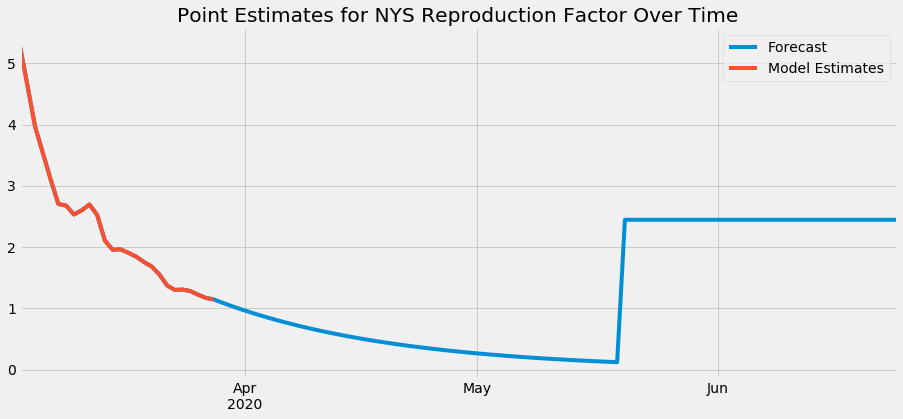

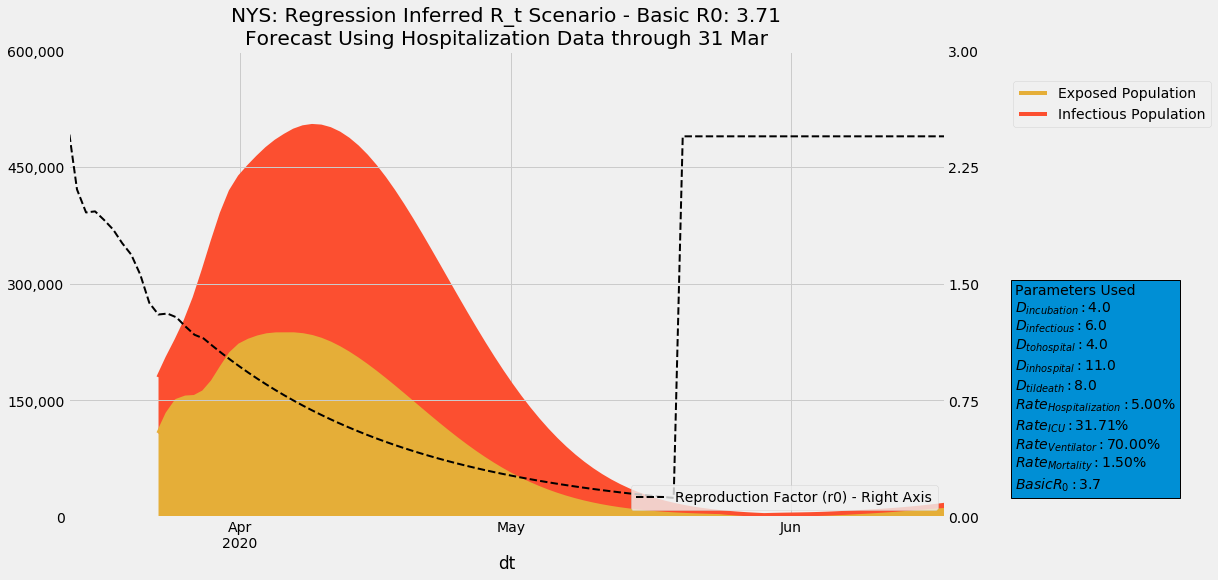

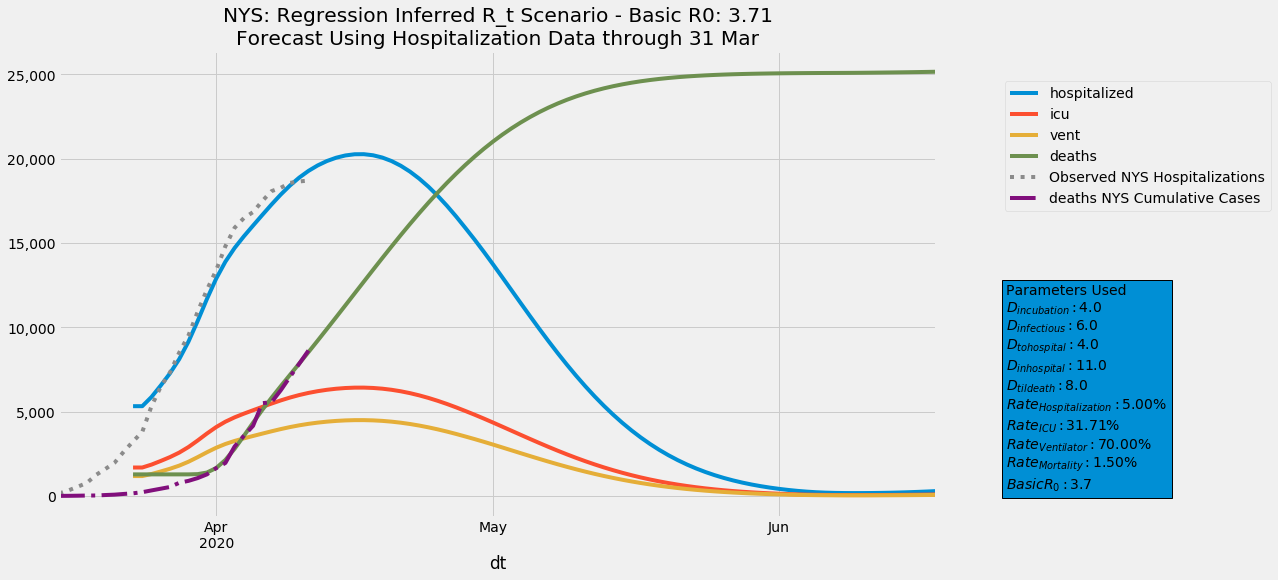

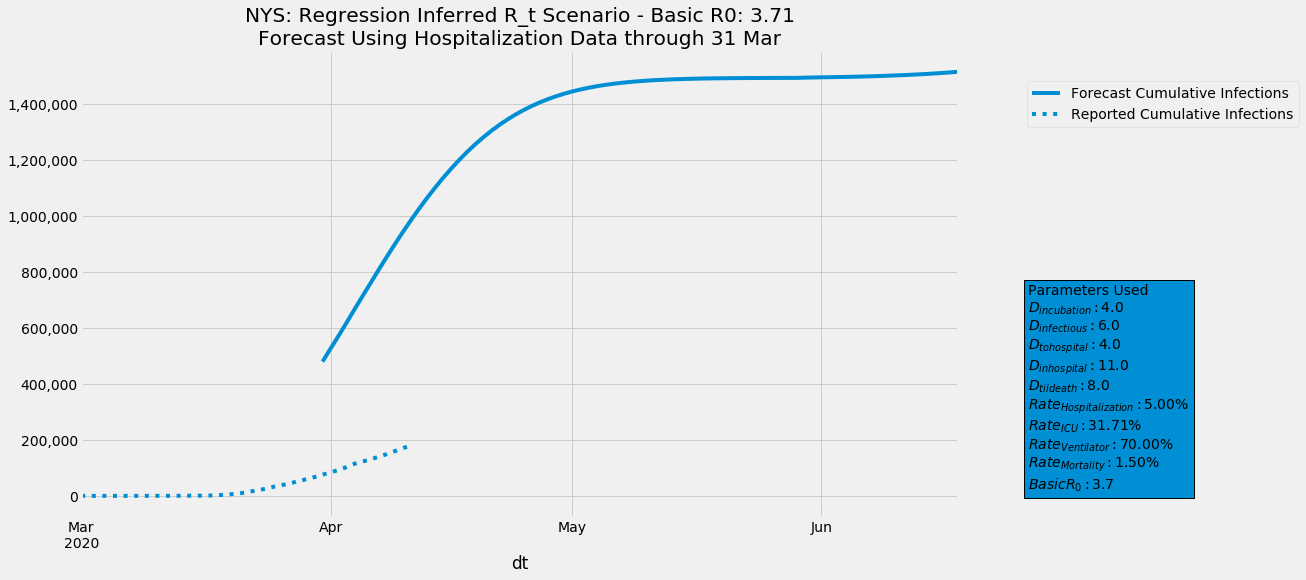

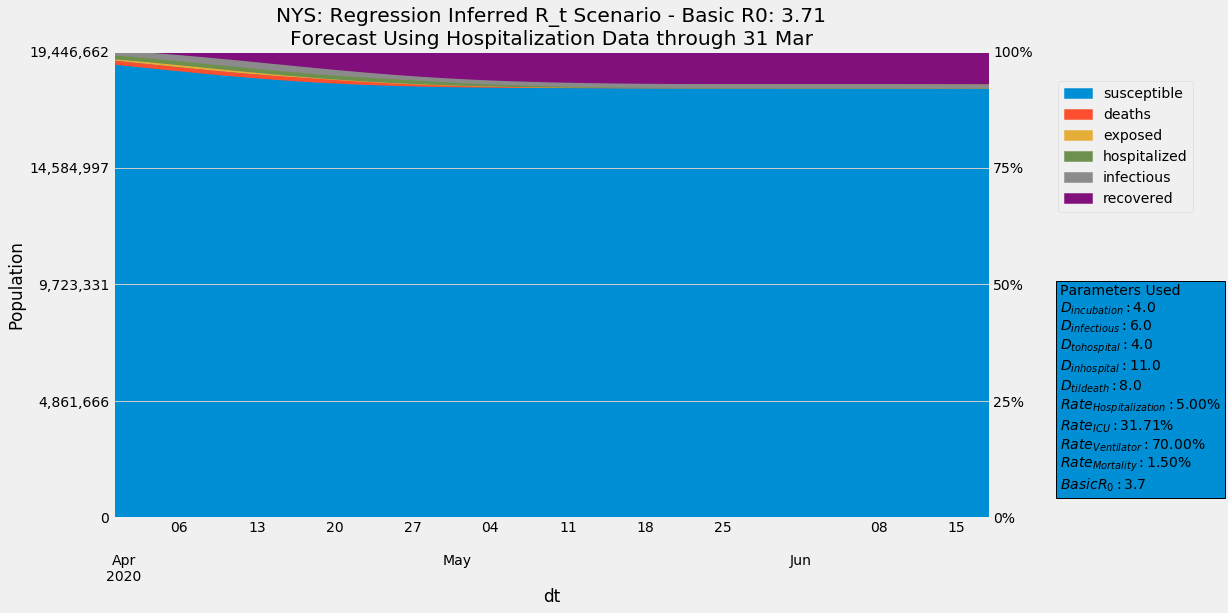

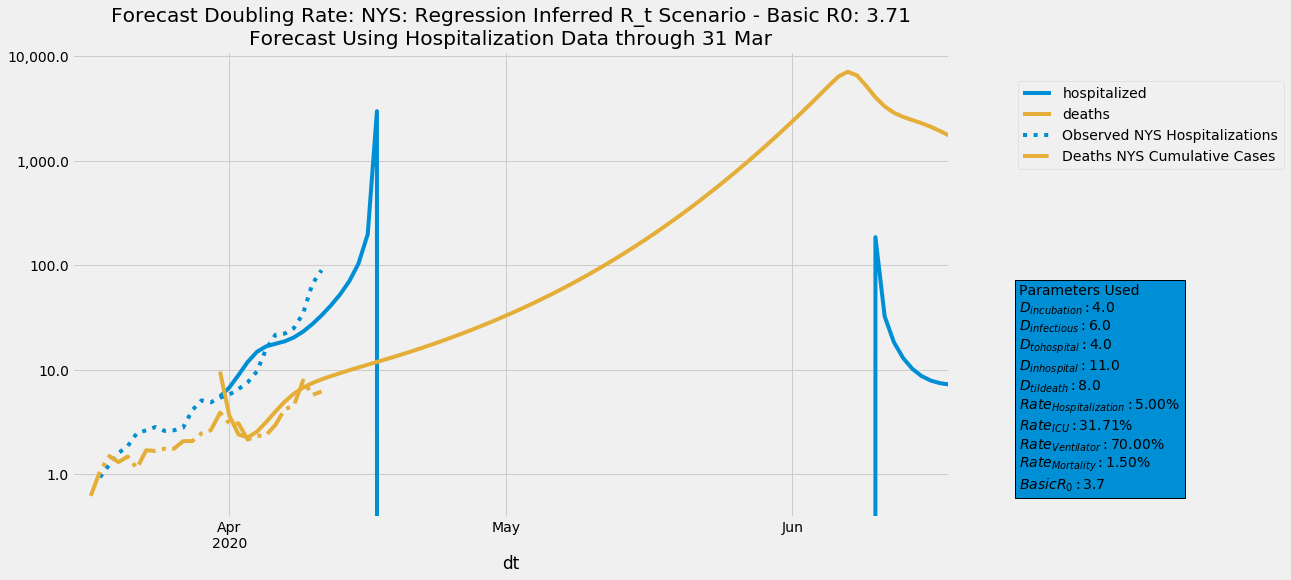

Peak Hospitalization Date:  17 Apr, 2020
Peak Hospitalization #: 20272
Peak ICU #: 6428
Peak Ventilator #: 4499


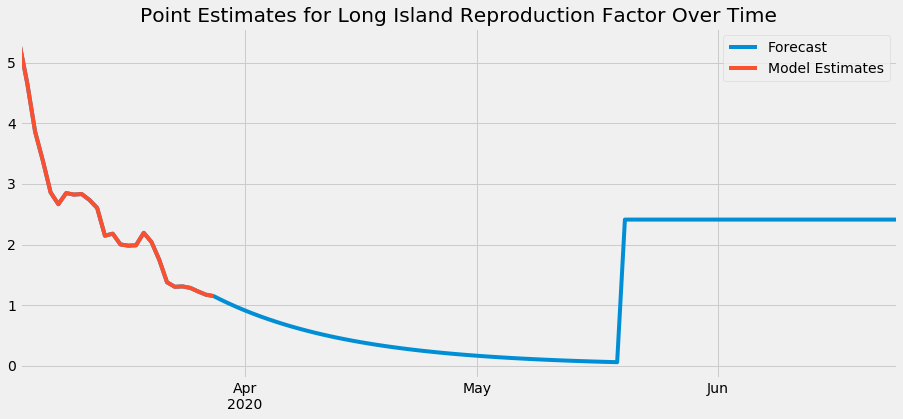

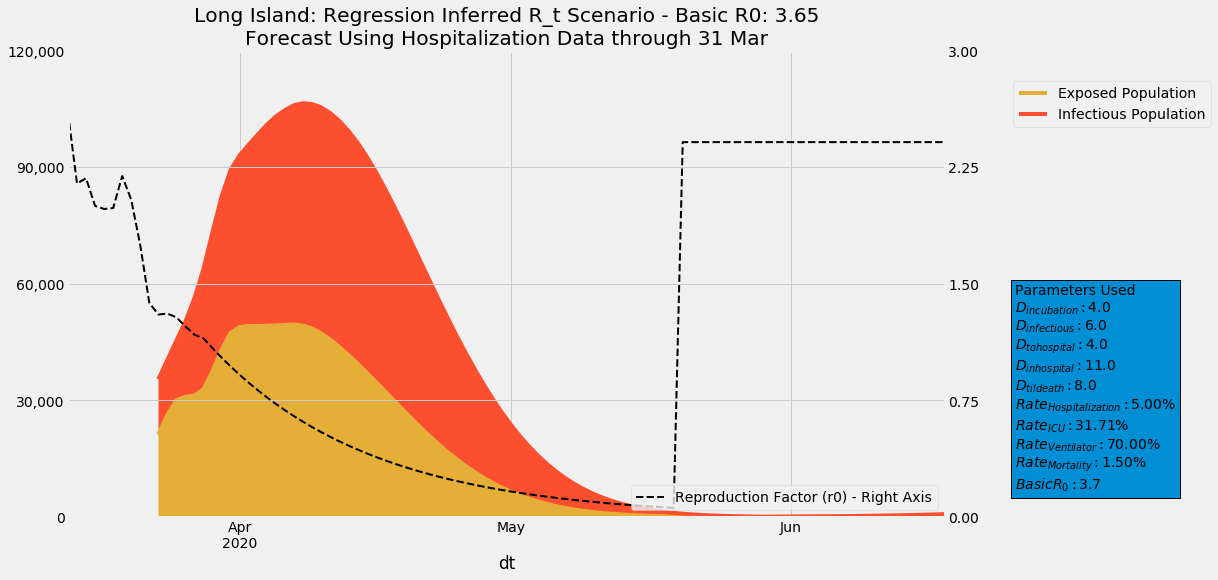

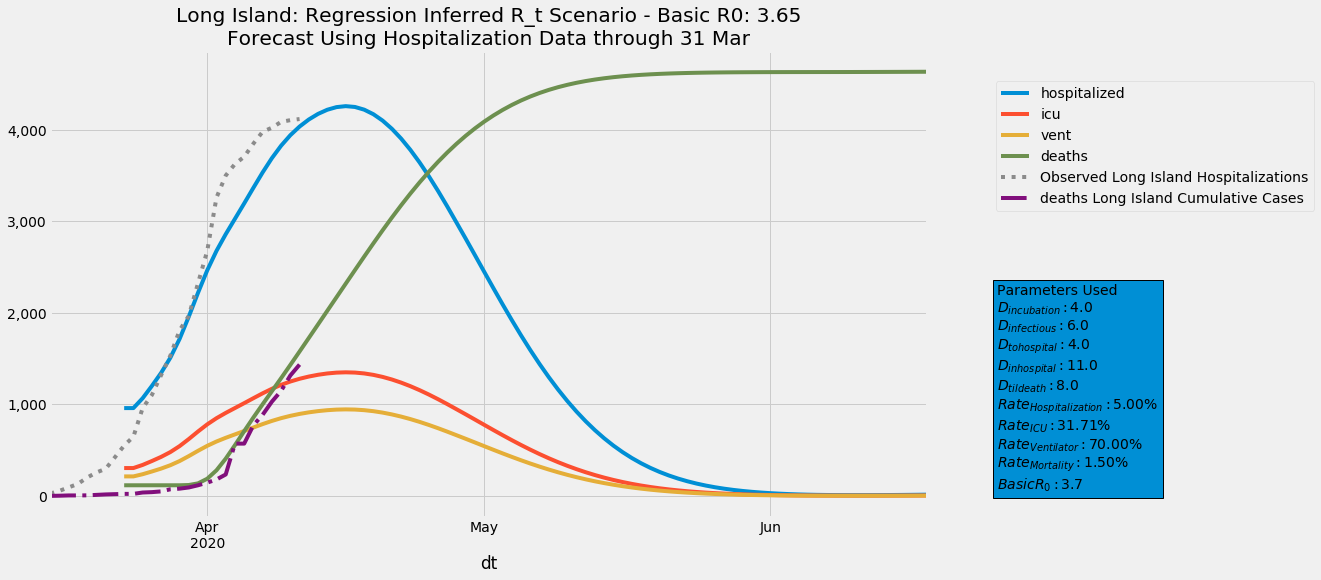

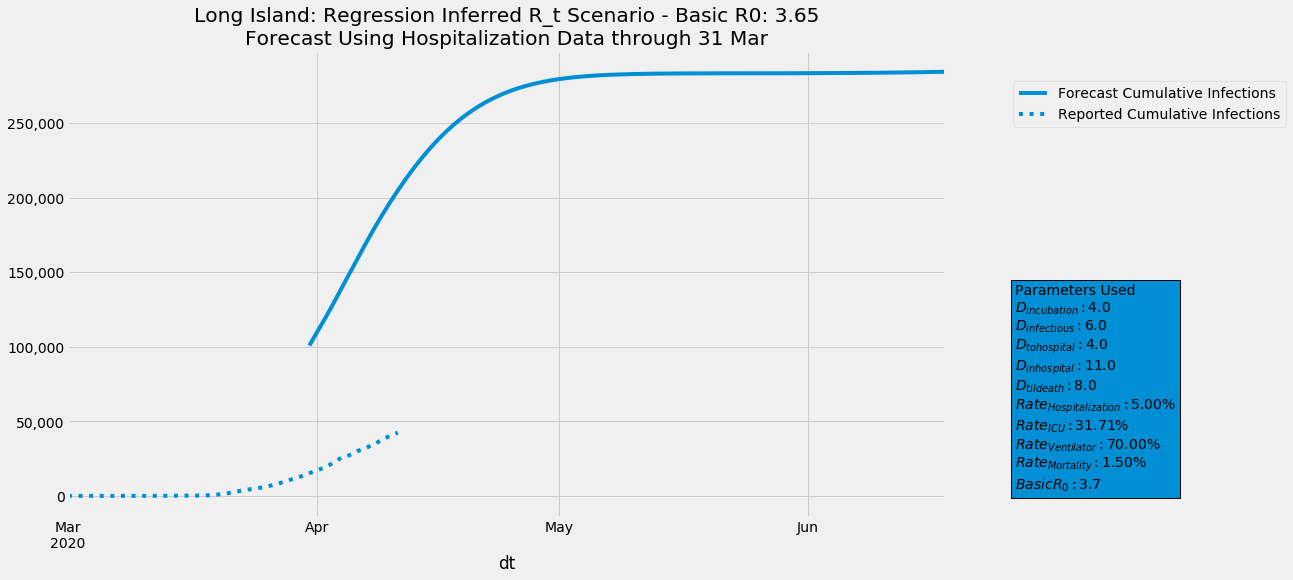

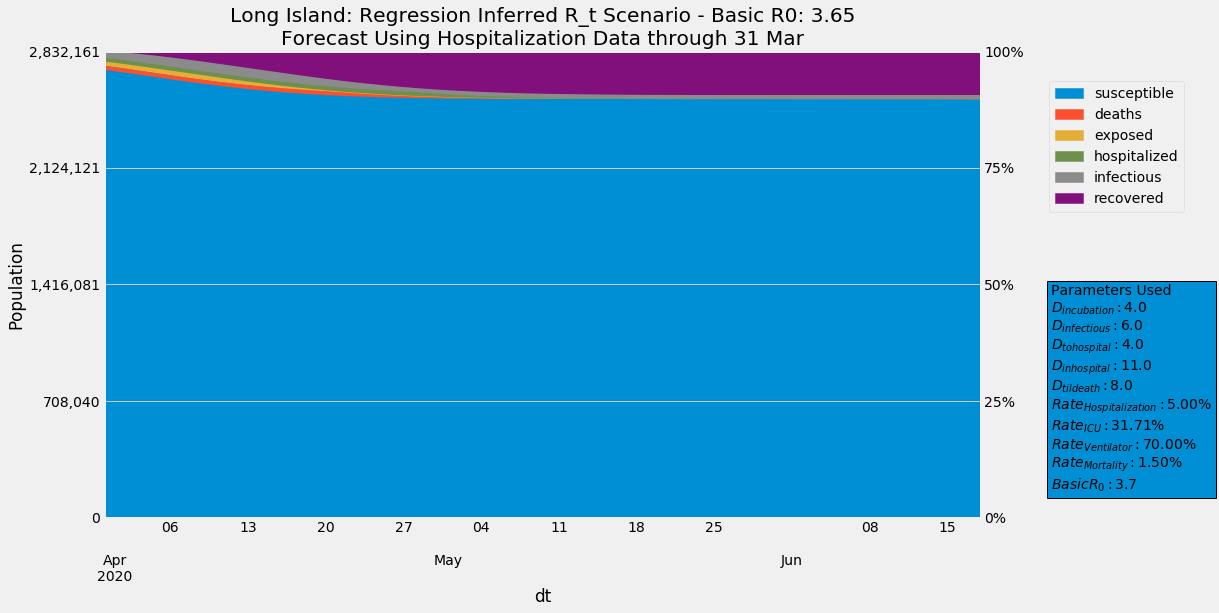

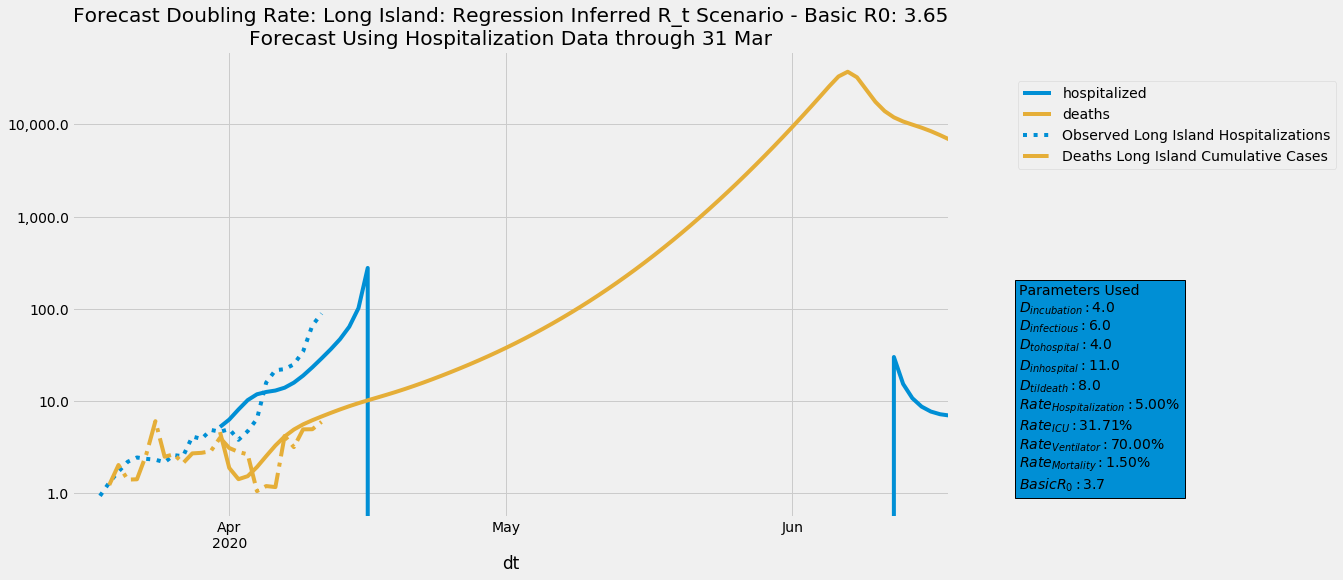

Peak Hospitalization Date:  16 Apr, 2020
Peak Hospitalization #: 4257
Peak ICU #: 1350
Peak Ventilator #: 945


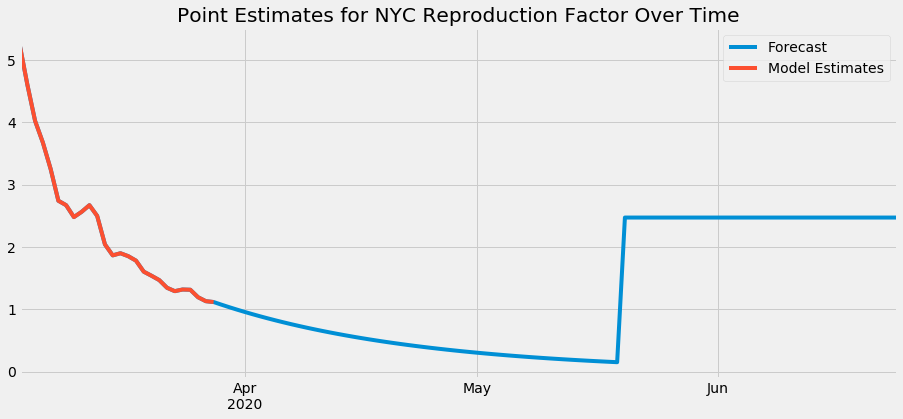

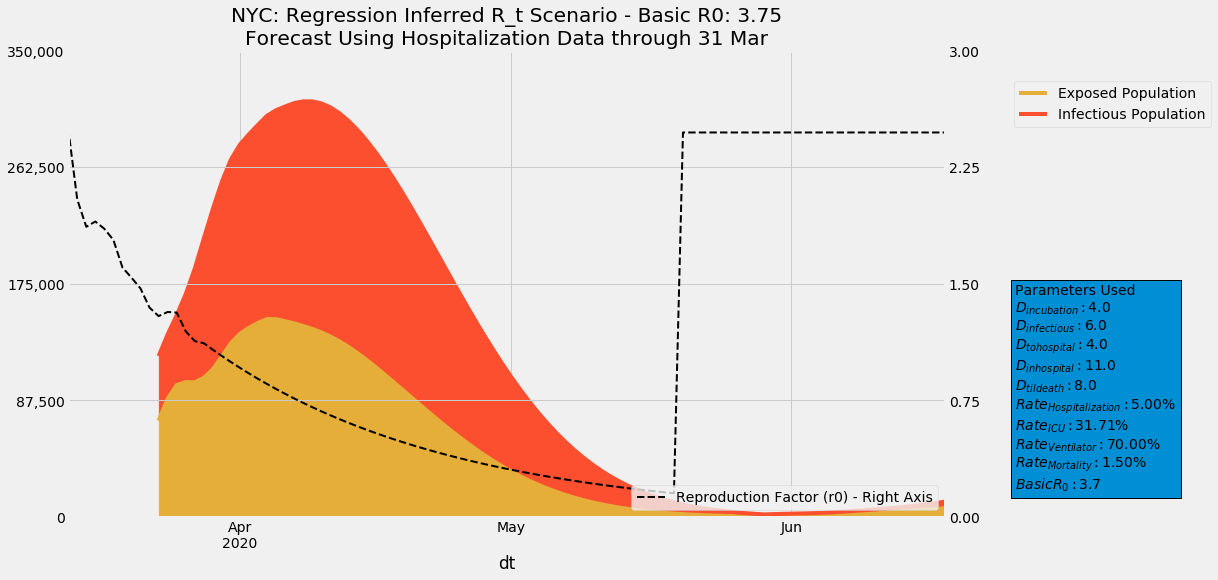

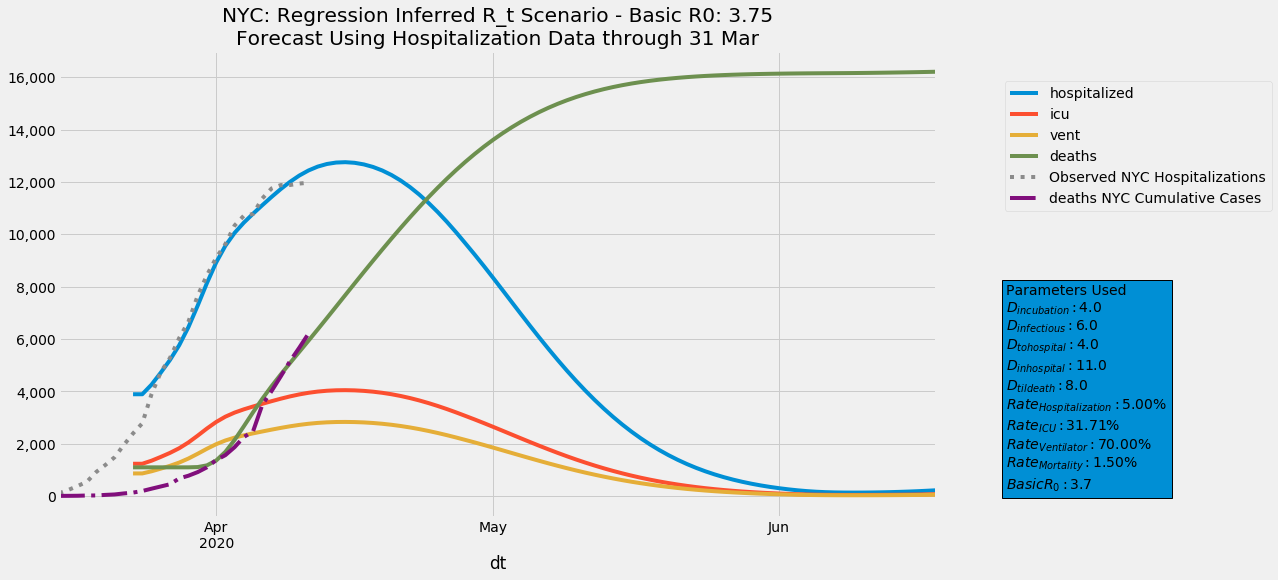

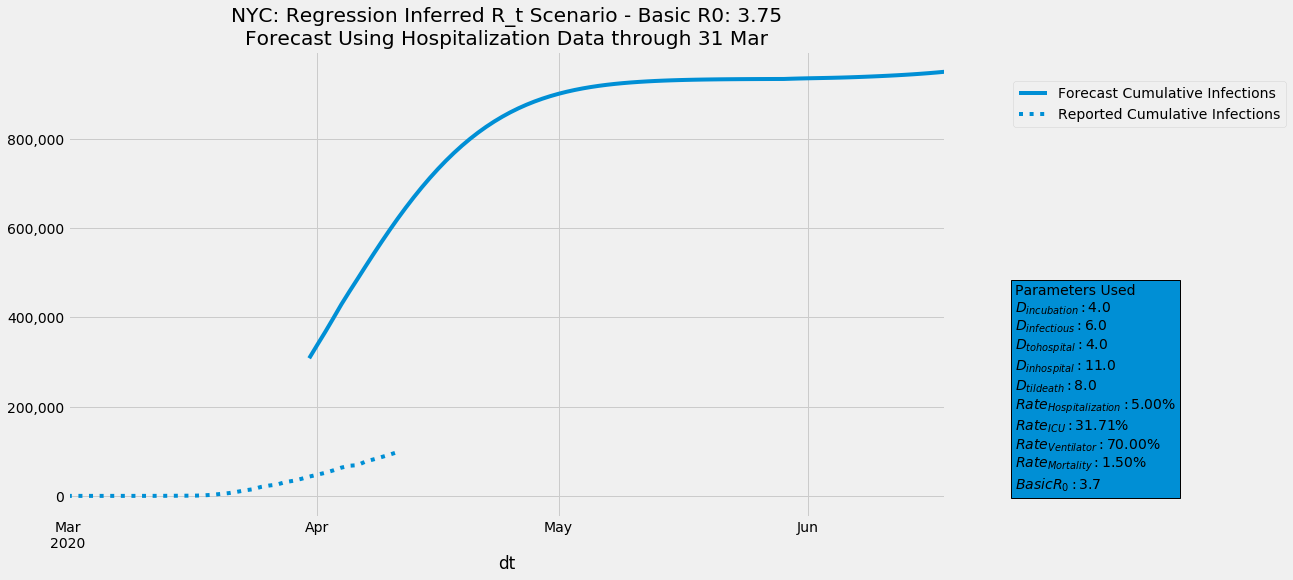

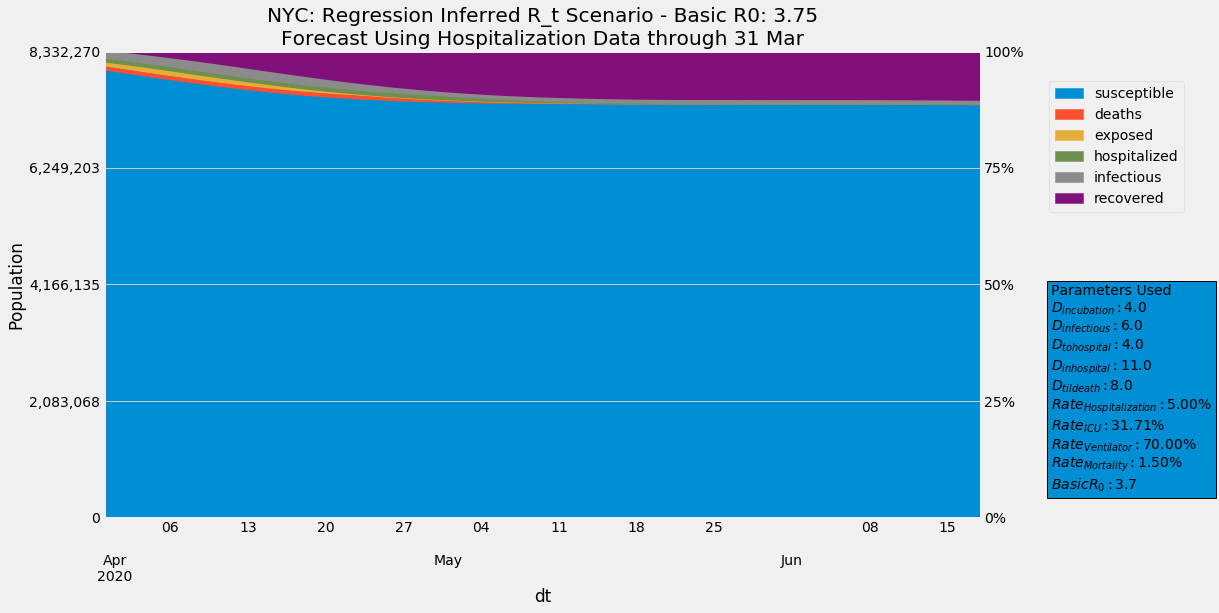

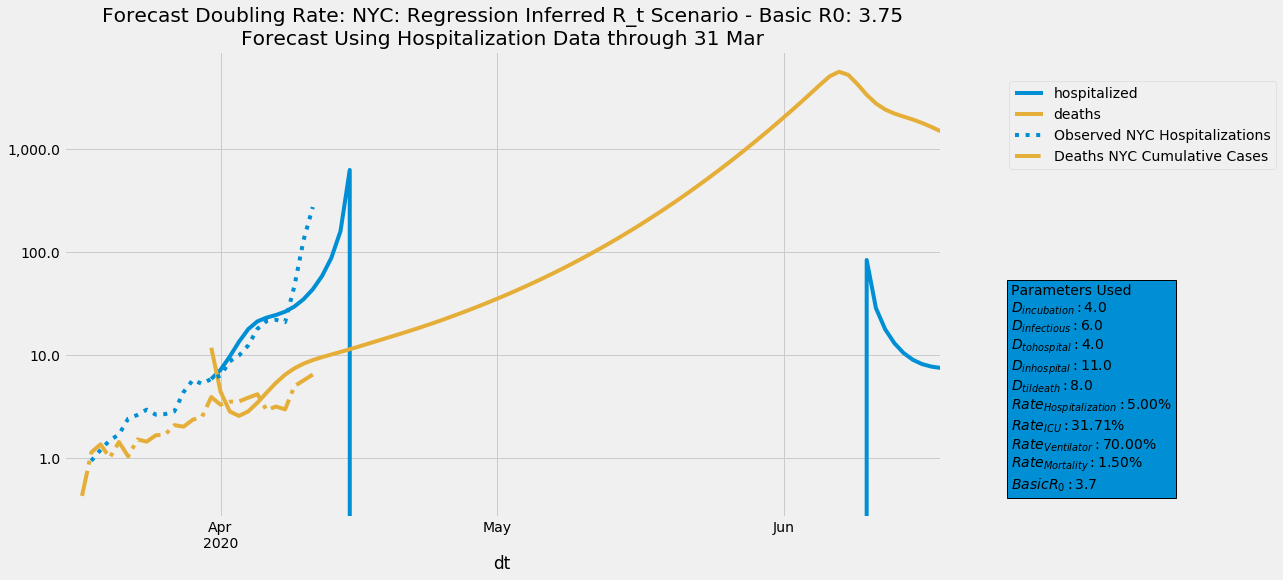

Peak Hospitalization Date:  15 Apr, 2020
Peak Hospitalization #: 12757
Peak ICU #: 4045
Peak Ventilator #: 2831


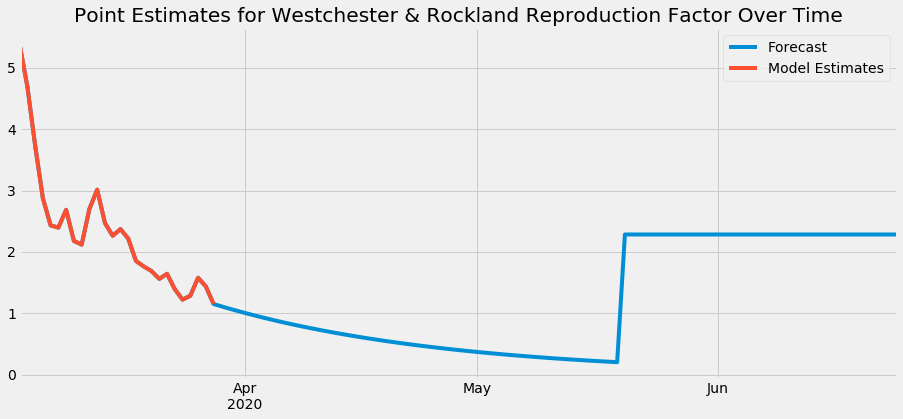

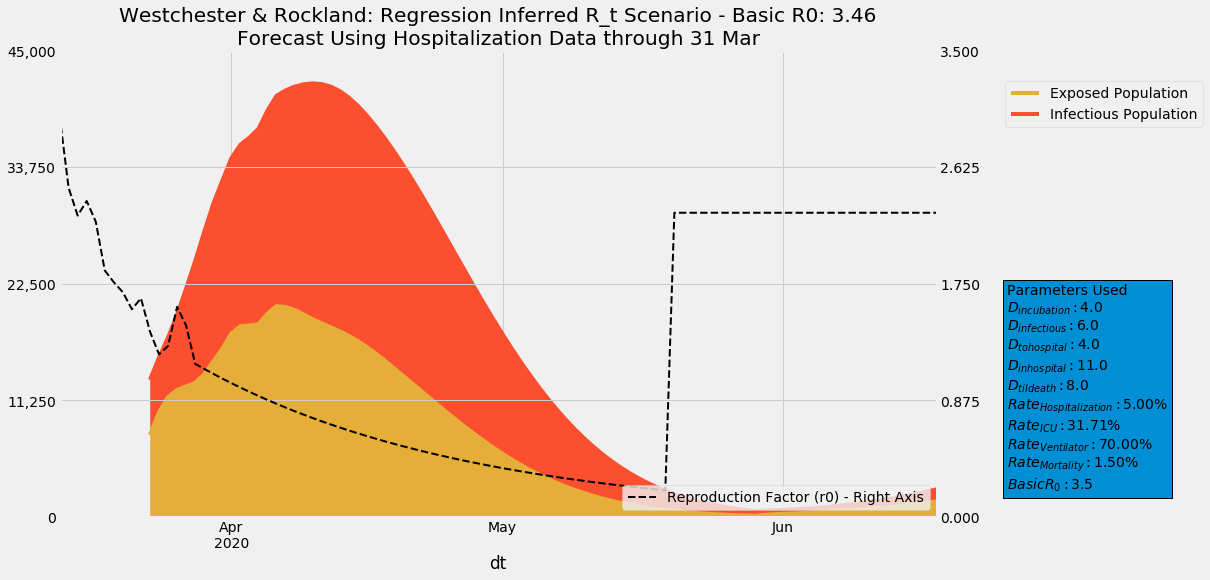

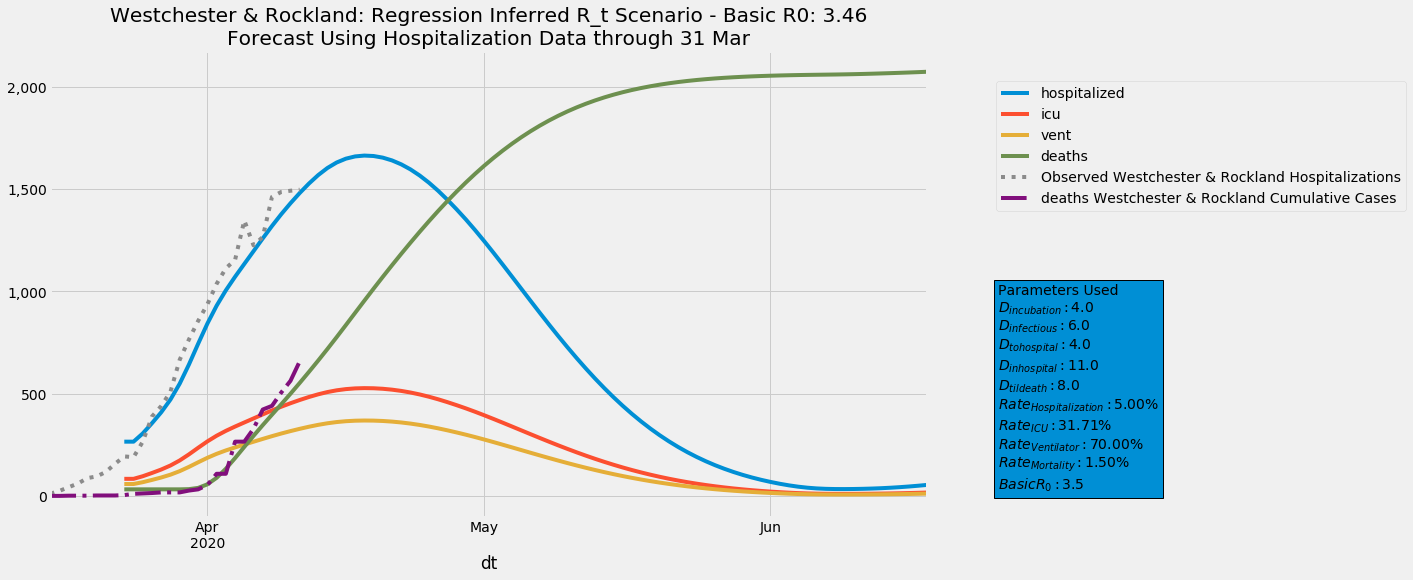

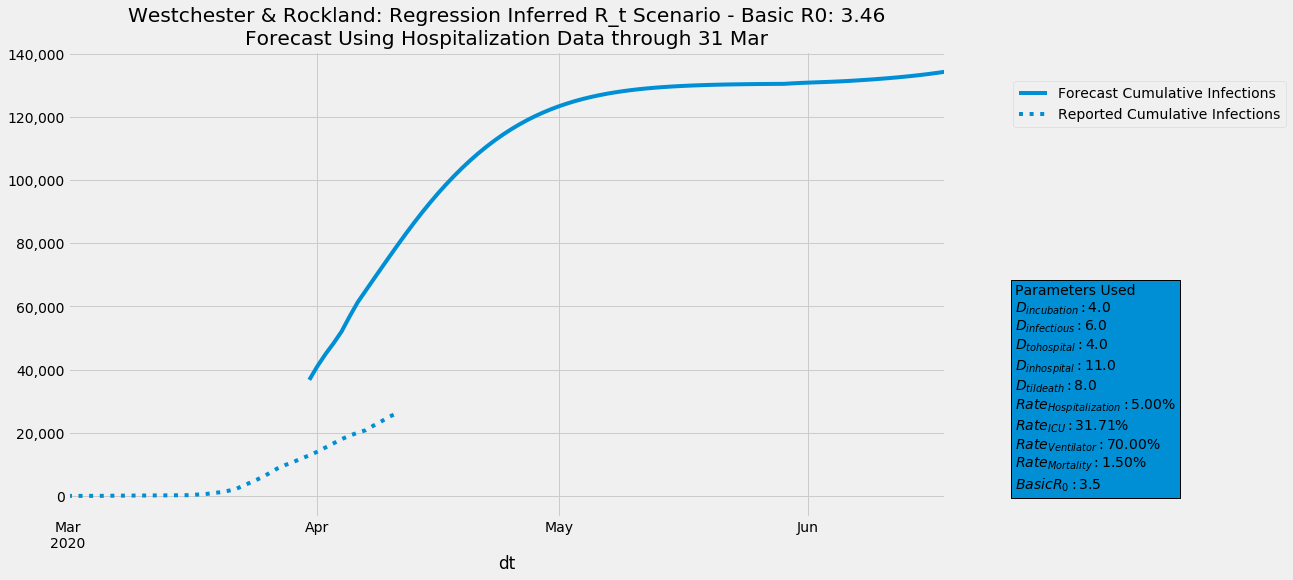

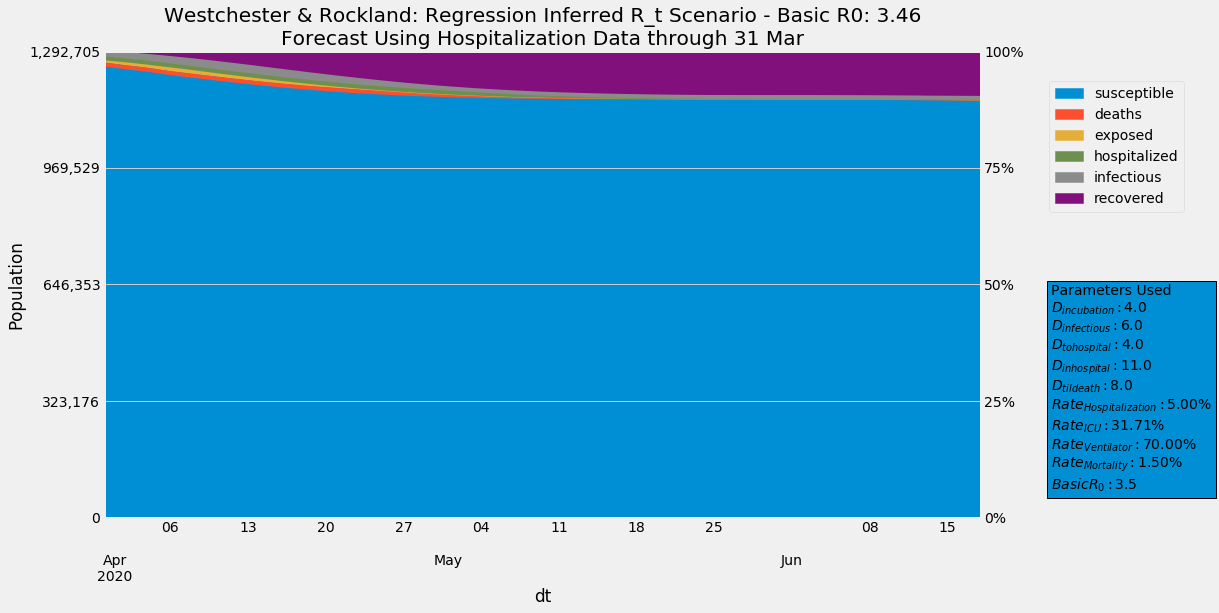

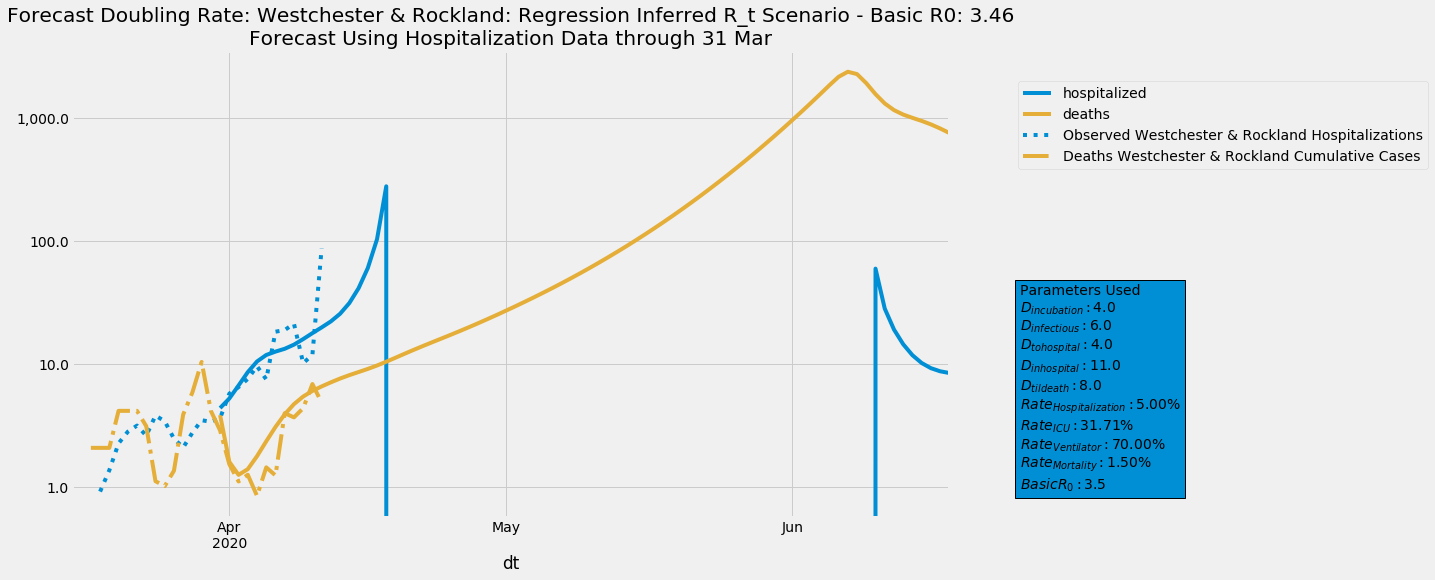

Peak Hospitalization Date:  18 Apr, 2020
Peak Hospitalization #: 1664
Peak ICU #: 528
Peak Ventilator #: 369


In [213]:
for region_name in s_nypop.index[:-1]:
    ########## POPULATION METRICS ################

    # Total Population
    total_pop = s_nypop[region_name]

    # Current Hospitalizations
    curr_hosp = df_hosps[region_name].loc[hosp_obs_dt]

    # Total # of cases currently recovered/immune
    curr_recovered = df_st_testing['recovered'].loc['NY'].fillna(0).loc[hosp_obs_dt]/s_nypop['NYS']*total_pop

    # Total # of deaths
    curr_deaths = df_reporting_fmt['deaths'][region_name].loc[
        (hosp_obs_dt - pd.Timedelta(days=(0))).normalize()]

    hosp_chg = (df_hosps[region_name] 
                - df_hosps[region_name].shift(int(d_incub+d_to_hosp)).fillna(0)).loc[hosp_obs_dt]

    curr_exposed = hosp_chg/hosp_rt*exposed_pct
    curr_infectious = hosp_chg/hosp_rt*(1-exposed_pct)

    # Susceptible Population
    curr_suspop = total_pop - curr_hosp - curr_exposed - curr_infectious - curr_recovered - curr_deaths

    r_t = est_r_t(df_hosps[region_name], 4, d_infect, d_incub + d_to_hosp + d_in_hosp/2)
    # r_t = est_r_t(df_hosps[region_name], 4, 2, d_incub + d_to_hosp+5)
    basic_r0 = r_t.iloc[:7].mean()

    mul_r_t = pd.Series((1+r_t.pct_change().rolling(7).mean().iloc[-1]), 
                        index=pd.date_range(r_t.index[-1]+pd.Timedelta(days=1),
                                        r_t.index[-1]+pd.Timedelta(days=d_to_forecast+d_incub+d_to_hosp)
                                       )).cumprod()
    fore_r_t = mul_r_t.mul(r_t.iloc[-1])
    fore_r_t = pd.concat([r_t, fore_r_t])
    fore_r_t.loc['2020-05-20':] = basic_r0*.66

    ax = fore_r_t.plot(label='Forecast', figsize=[14,6], legend=True,
                  title='Point Estimates for {} Reproduction Factor Over Time'.format(region_name))
    r_t.plot(ax=ax, label='Model Estimates', legend=True)

    r_dates = list(pd.DataFrame(fore_r_t).itertuples(index=True))
    # Scenario Name
    scenario_name = "Regression Inferred R_t"

    df_agg, df_all_cohorts = run_cohort_model(
        d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, curr_recovered, curr_deaths, 
                     hosp_obs_dt, basic_r0, r_dates, 
                     d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                     d_til_death, d_in_hosp_mild, d_to_hosp, 
                     icu_rt, d_in_icu, vent_rt,
                     scenario_name, region_name, df_hosps, df_reporting_fmt)
# df_scenarios[scenario_name] = df_agg.stack()

# Scenarios

In [197]:
df_scenarios = pd.DataFrame()

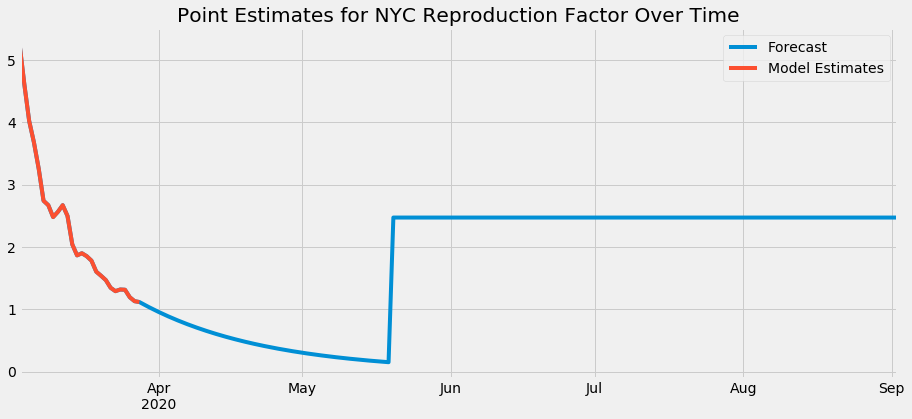

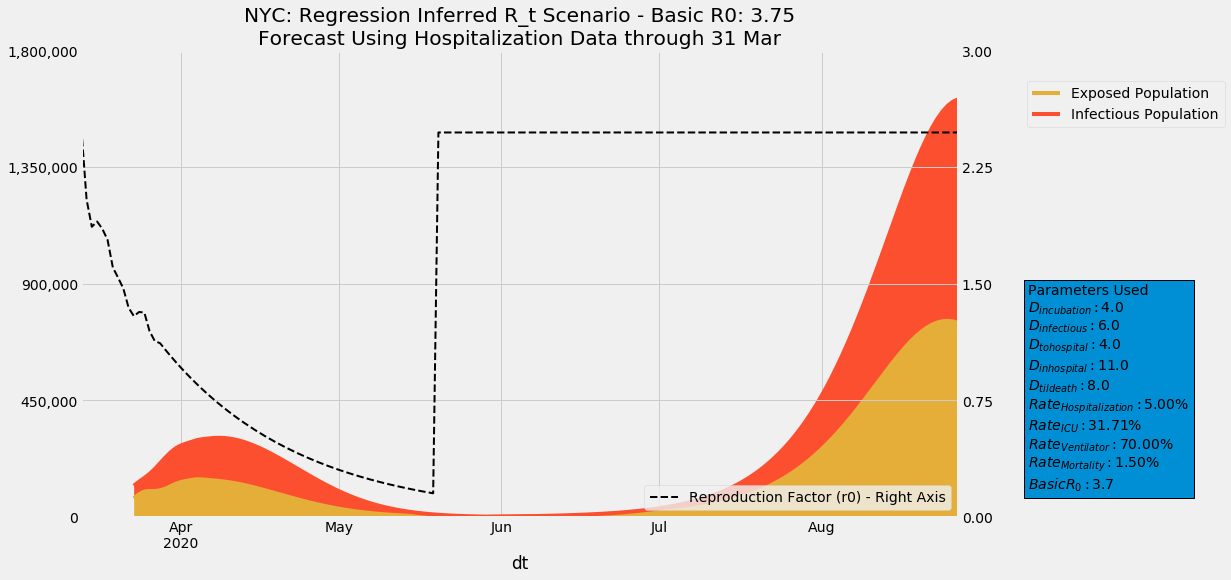

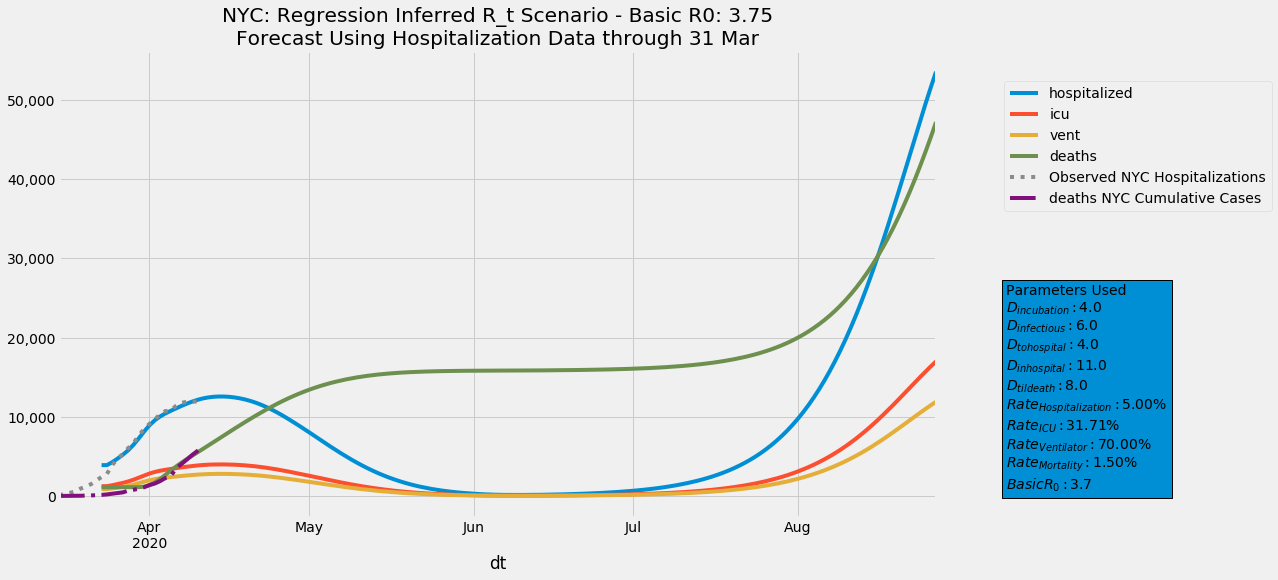

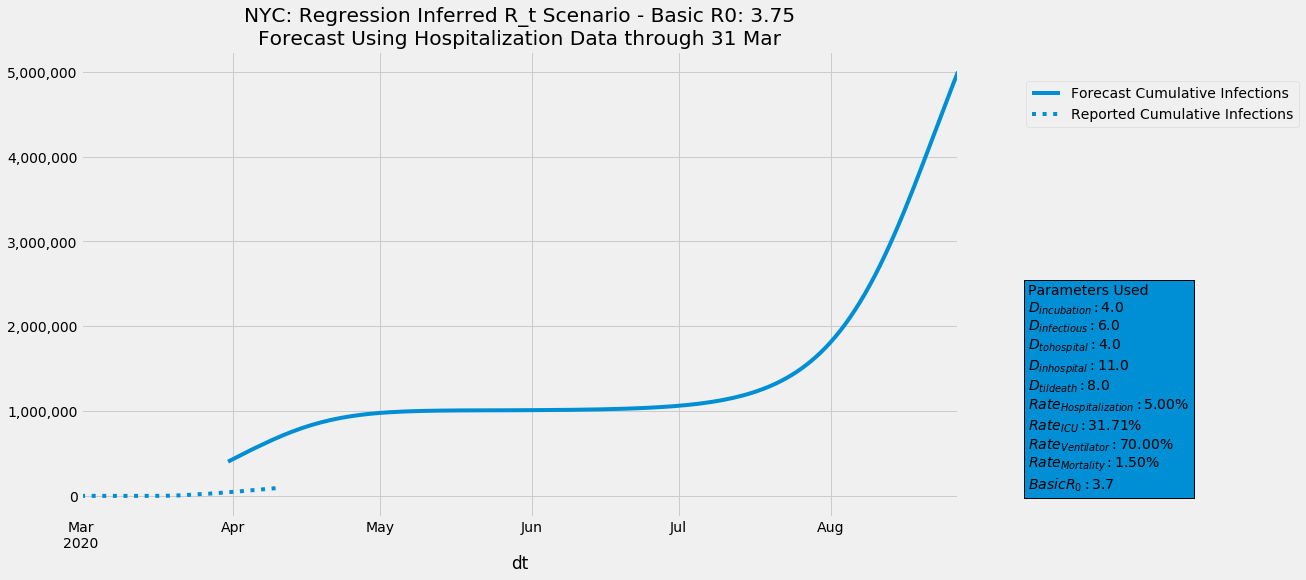

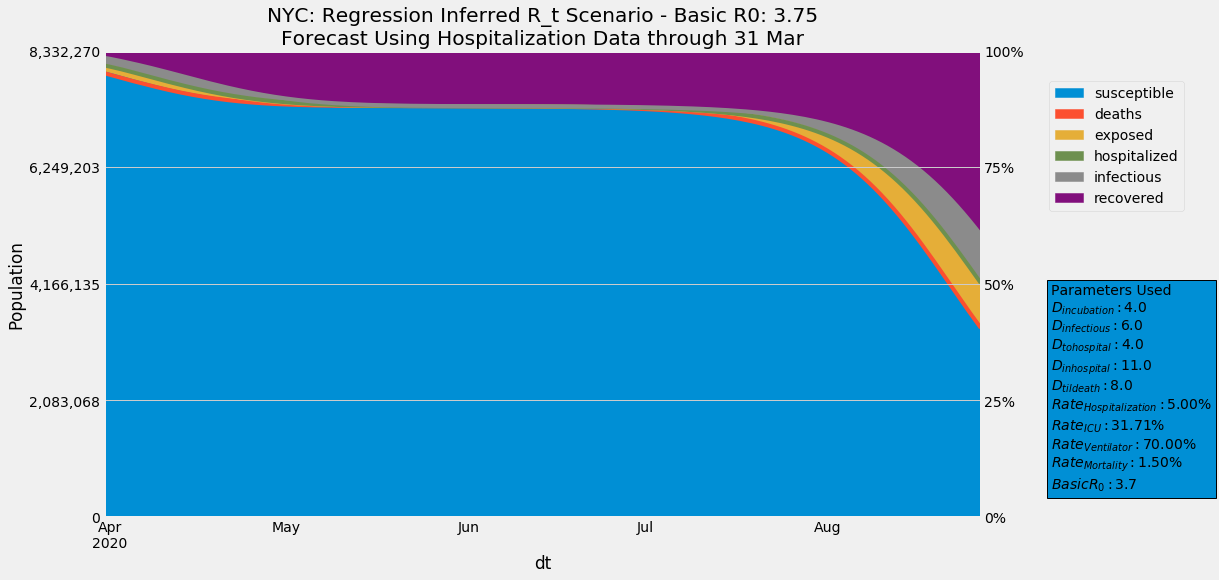

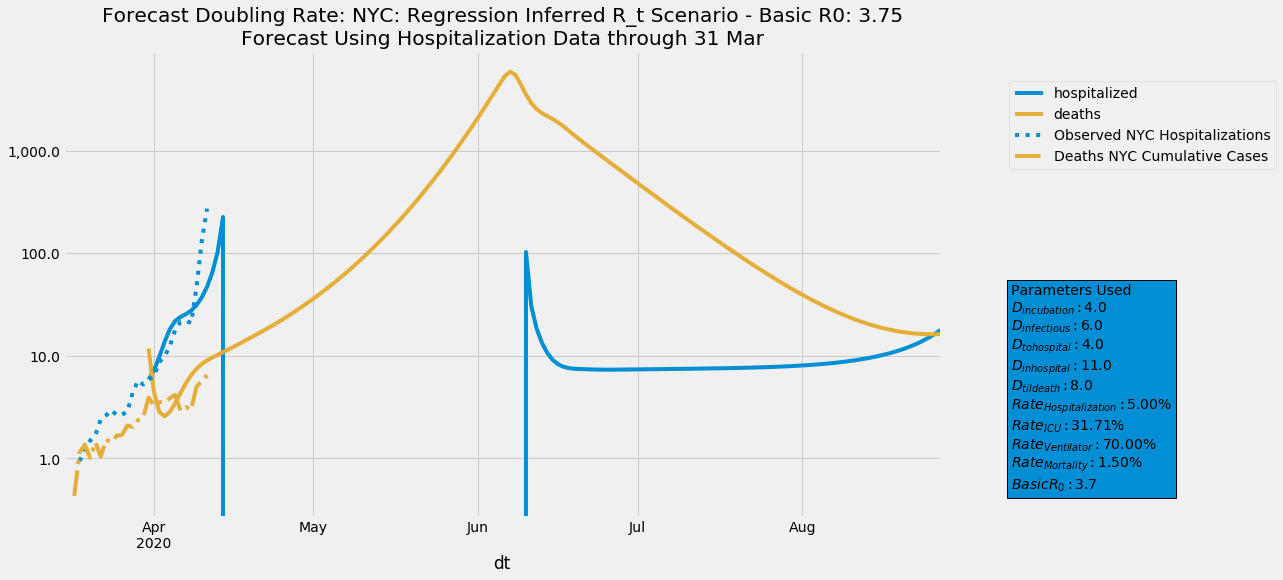

Peak Hospitalization Date:  27 Aug, 2020
Peak Hospitalization #: 53550
Peak ICU #: 16979
Peak Ventilator #: 11886


In [198]:
r_t = est_r_t(df_hosps[region_name], 4, d_infect, d_incub + d_to_hosp + d_in_hosp/2)
# r_t = est_r_t(df_hosps[region_name], 4, 2, d_incub + d_to_hosp+5)
basic_r0 = r_t.iloc[:7].mean()

mul_r_t = pd.Series((1+r_t.pct_change().rolling(7).mean().iloc[-1]), 
                    index=pd.date_range(r_t.index[-1]+pd.Timedelta(days=1),
                                    r_t.index[-1]+pd.Timedelta(days=d_to_forecast+d_incub+d_to_hosp)
                                   )).cumprod()
fore_r_t = mul_r_t.mul(r_t.iloc[-1])
fore_r_t = pd.concat([r_t, fore_r_t])
fore_r_t.loc['2020-05-20':] = basic_r0*.66

ax = fore_r_t.plot(label='Forecast', figsize=[14,6], legend=True,
              title='Point Estimates for {} Reproduction Factor Over Time'.format(region_name))
r_t.plot(ax=ax, label='Model Estimates', legend=True)

r_dates = list(pd.DataFrame(fore_r_t).itertuples(index=True))
# Scenario Name
scenario_name = "Regression Inferred R_t"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()

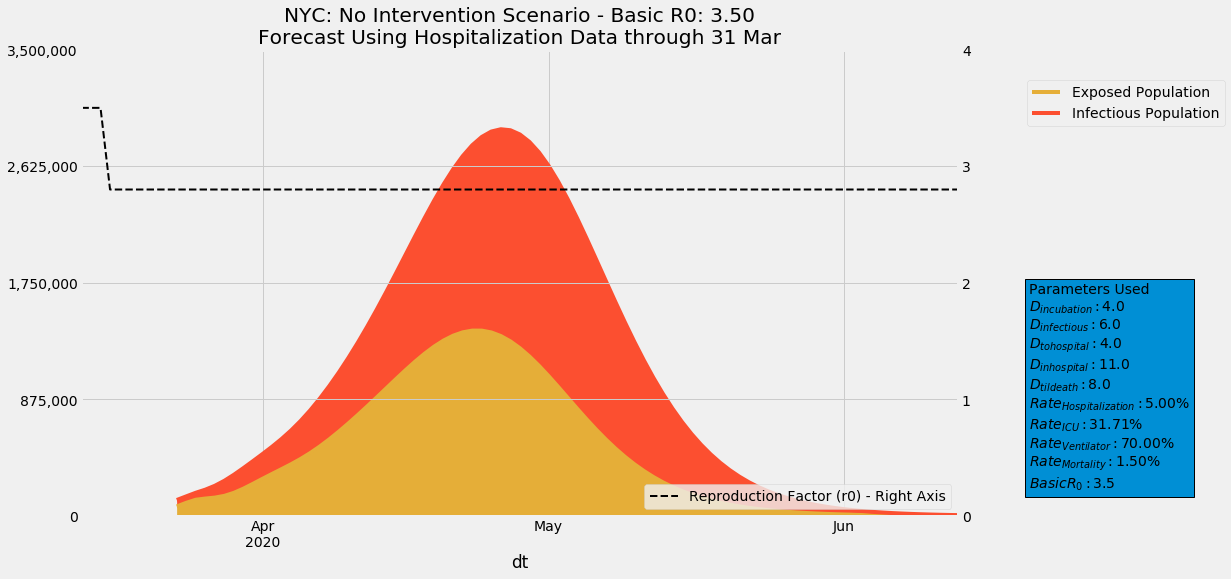

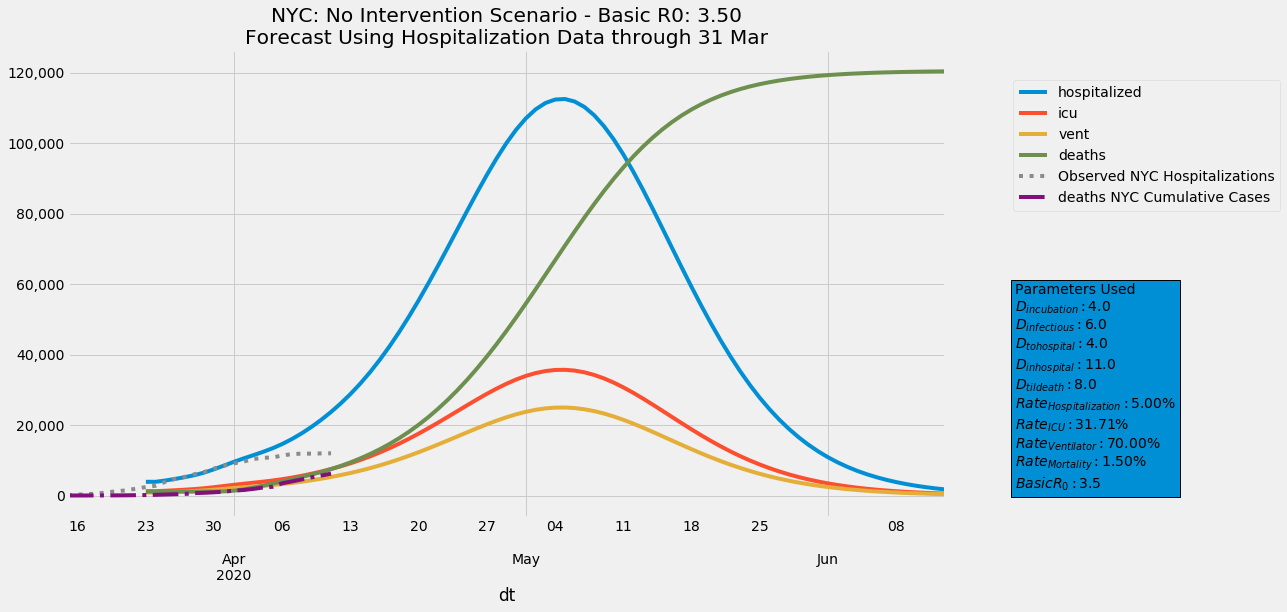

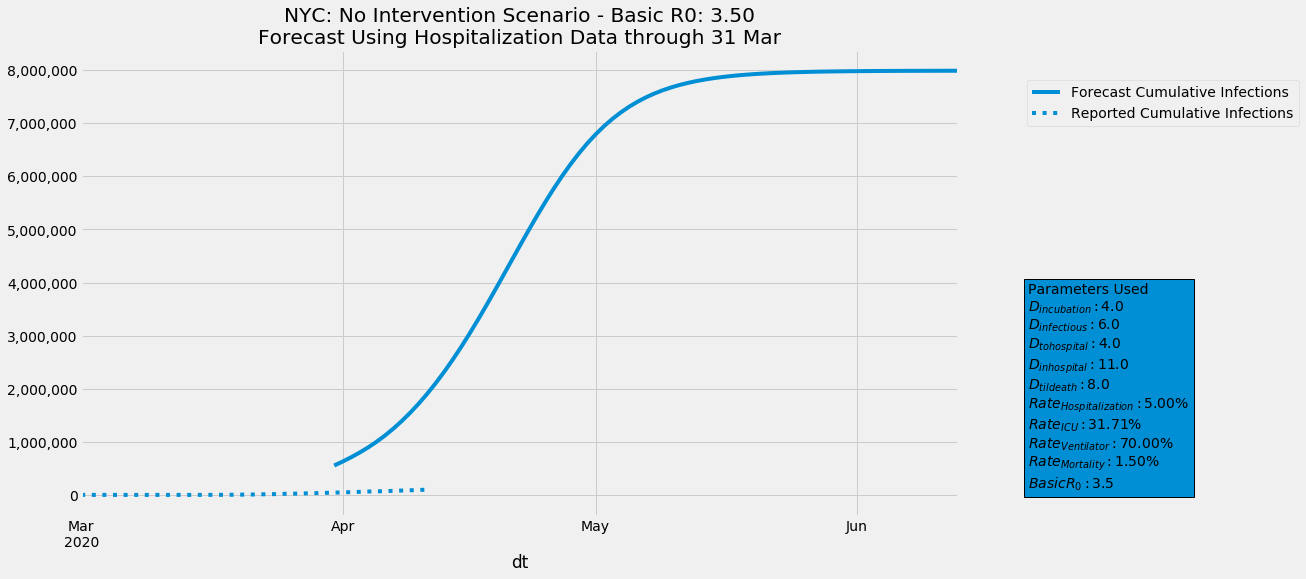

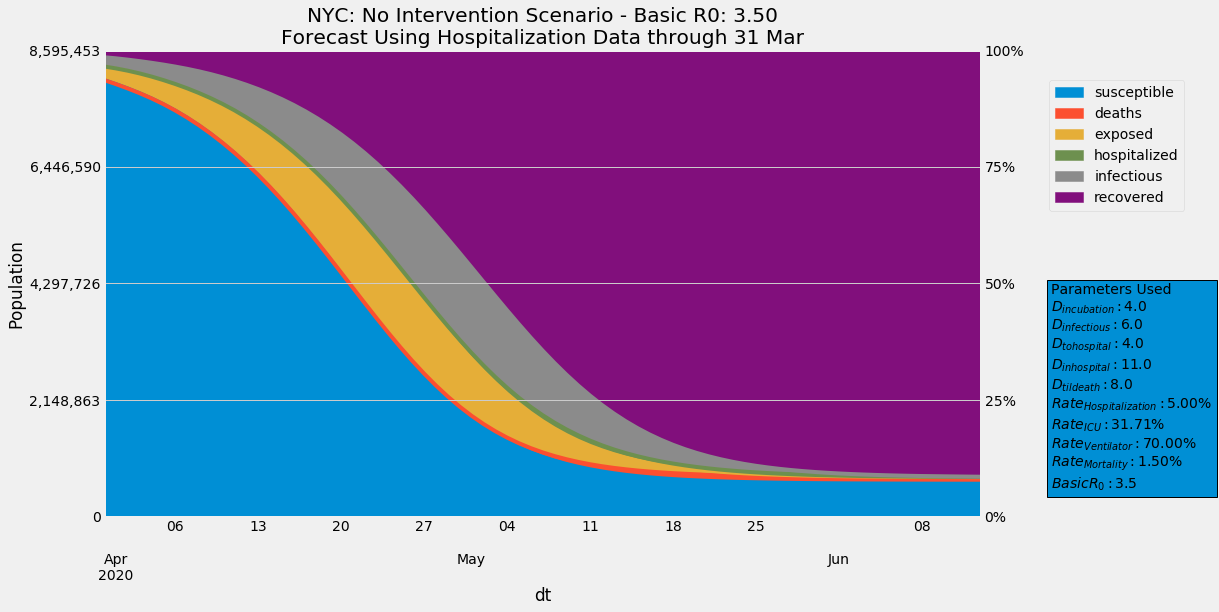

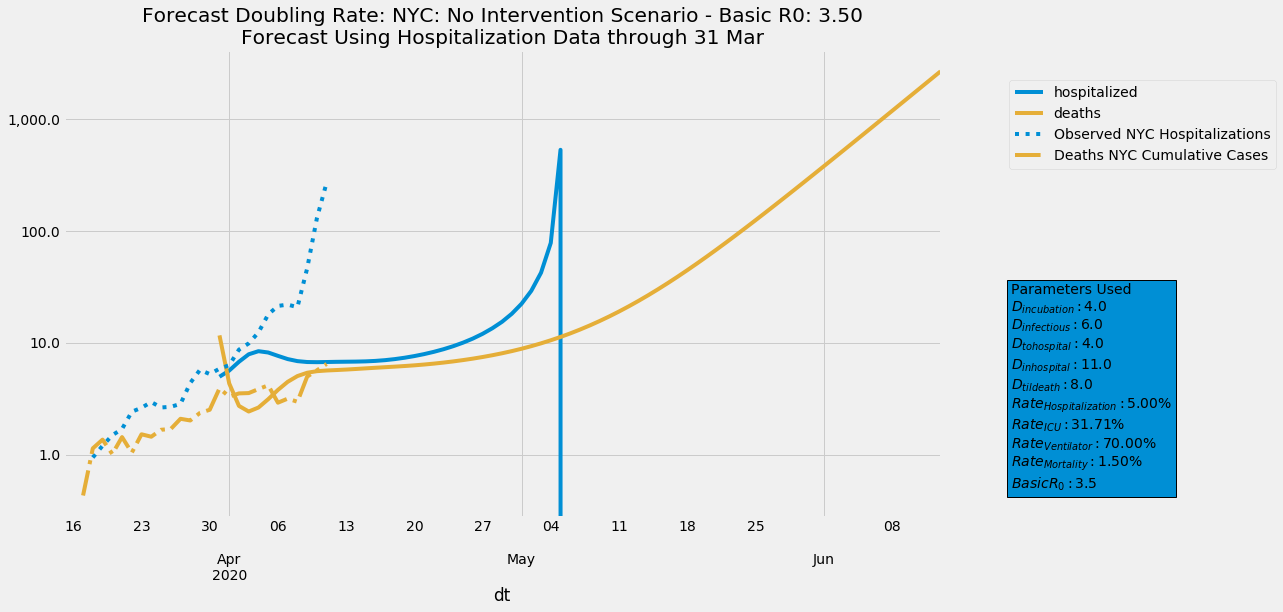

Peak Hospitalization Date:  05 May, 2020
Peak Hospitalization #: 112499
Peak ICU #: 35670
Peak Ventilator #: 24969


In [127]:
# Pre-intervention R0
basic_r0 = 3.5

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.8)]

# Scenario Name
scenario_name = "No Intervention"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


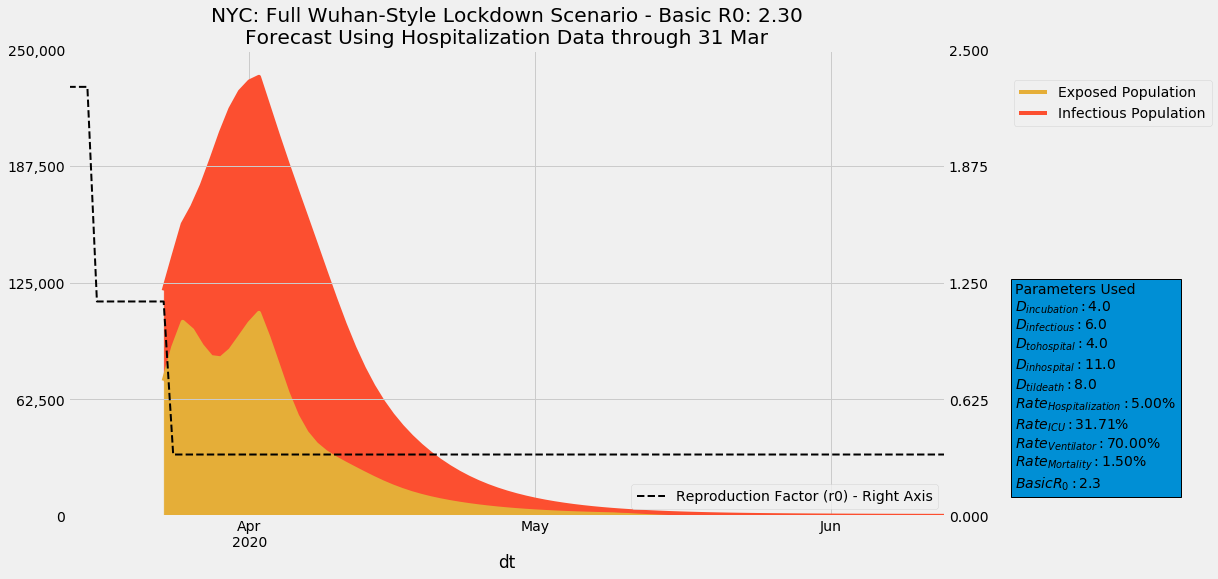

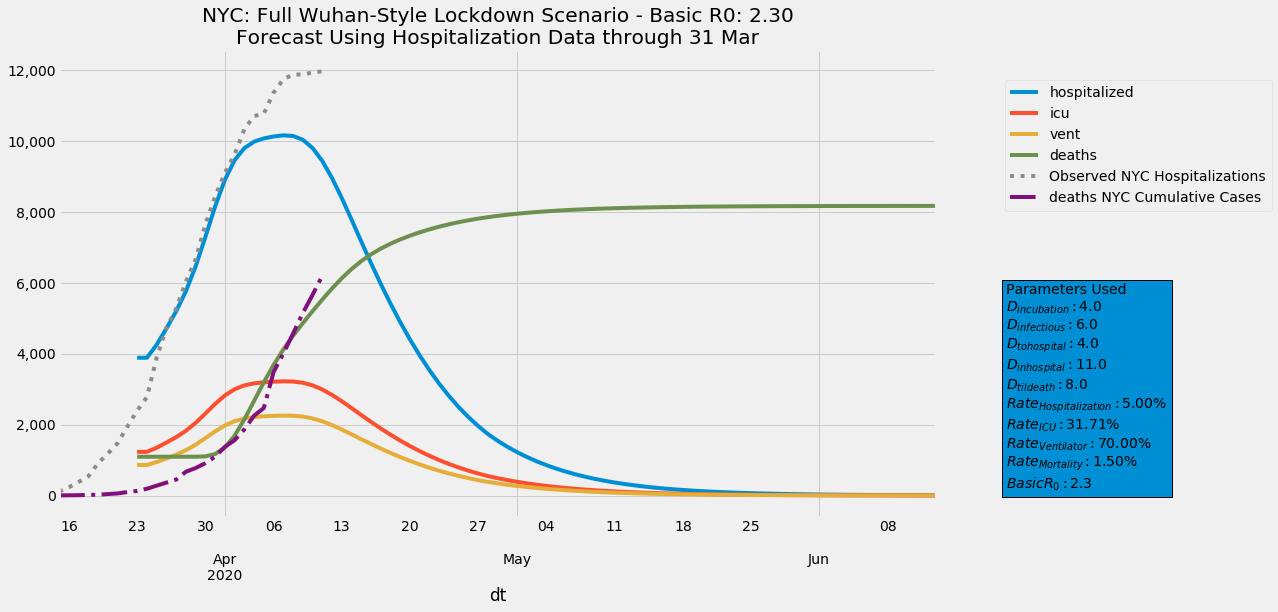

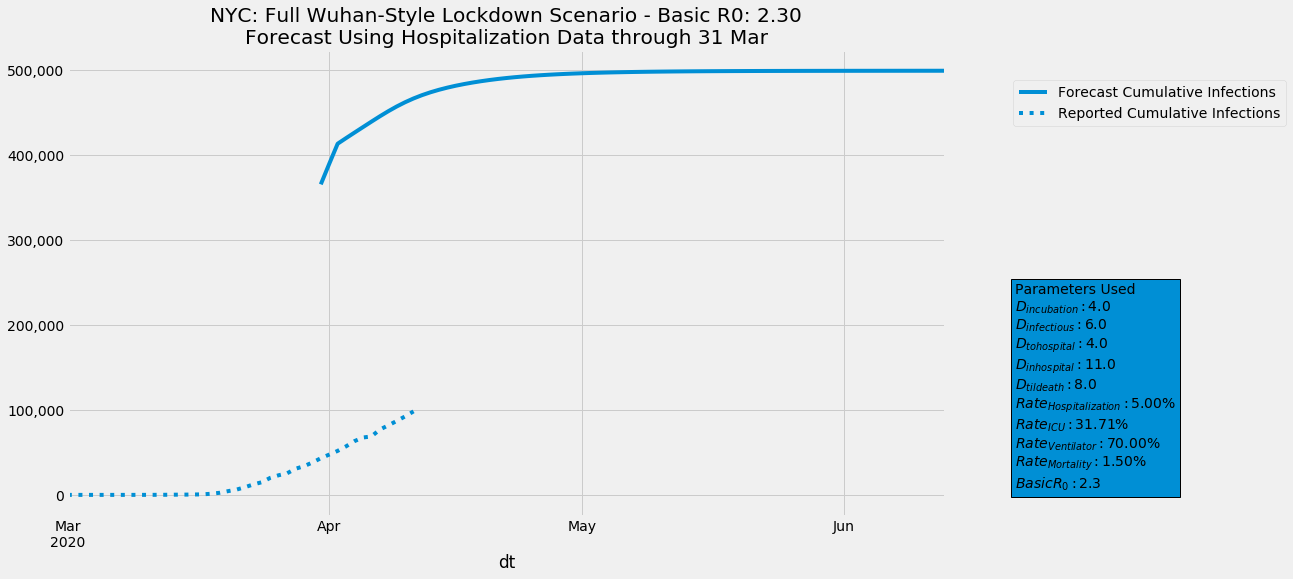

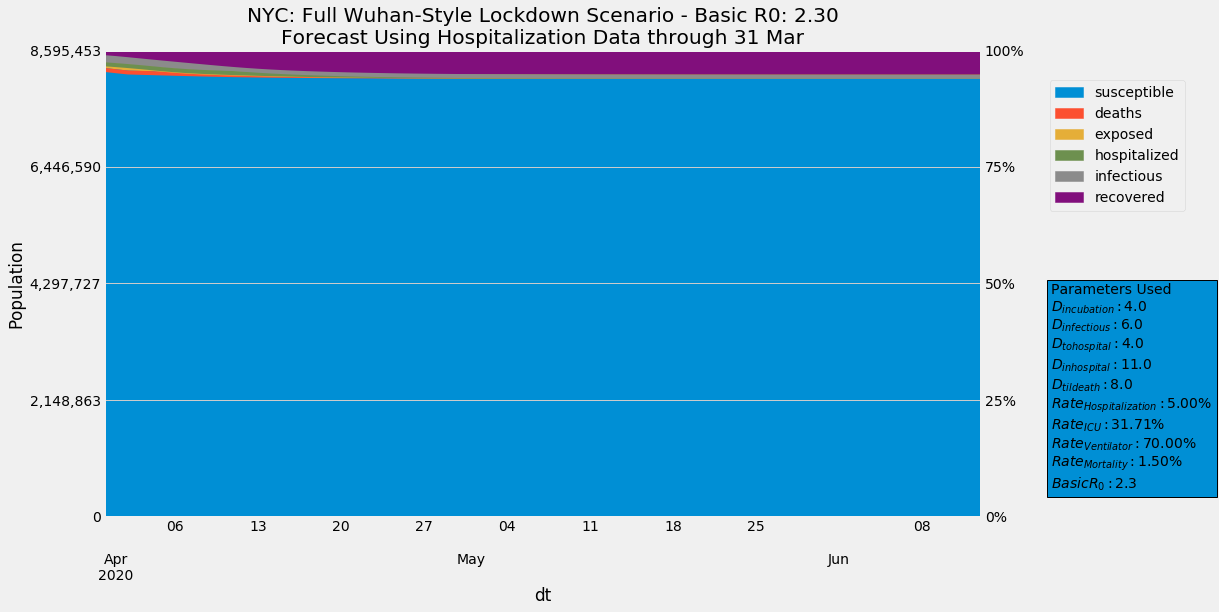

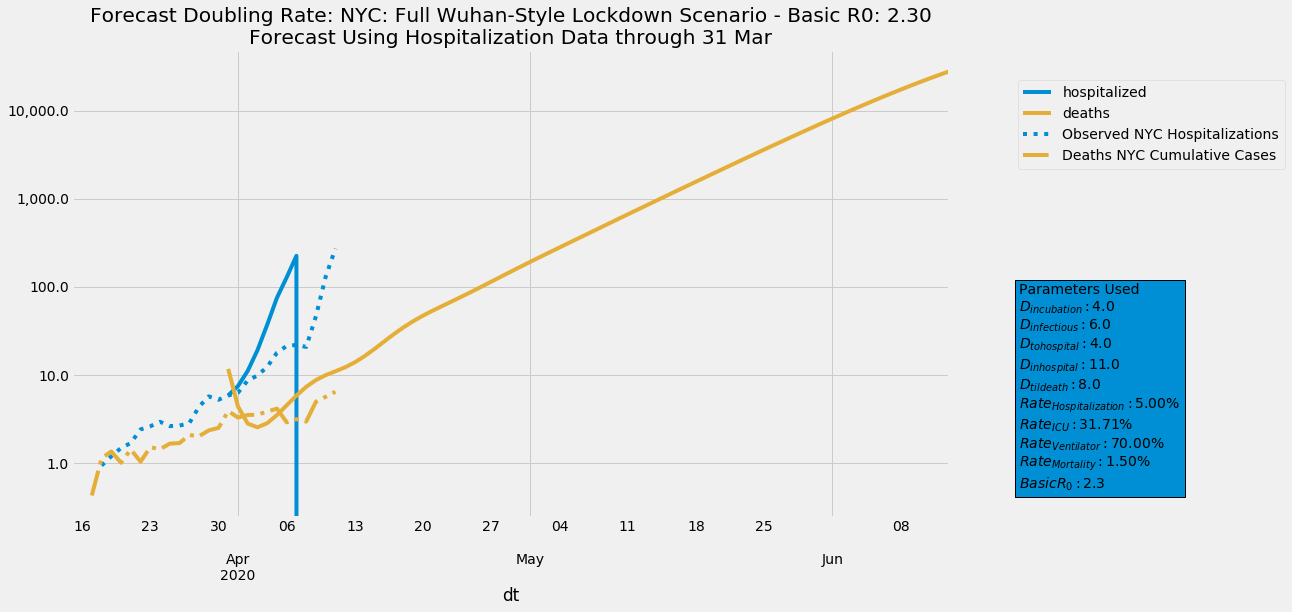

Peak Hospitalization Date:  07 Apr, 2020
Peak Hospitalization #: 10165
Peak ICU #: 3223
Peak Ventilator #: 2256


In [128]:
# Pre-intervention R0
basic_r0 = 2.3

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.5), ('2020-03-24', 0.33), ('2021-05-15',basic_r0*.75)]

# Scenario Name
scenario_name = "Full Wuhan-Style Lockdown"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


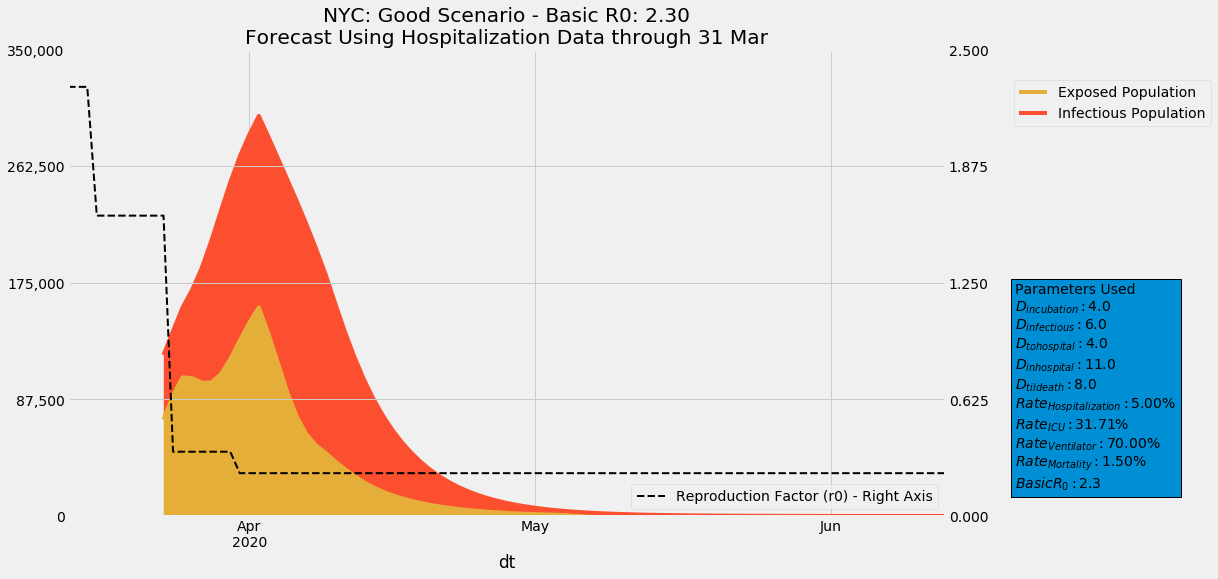

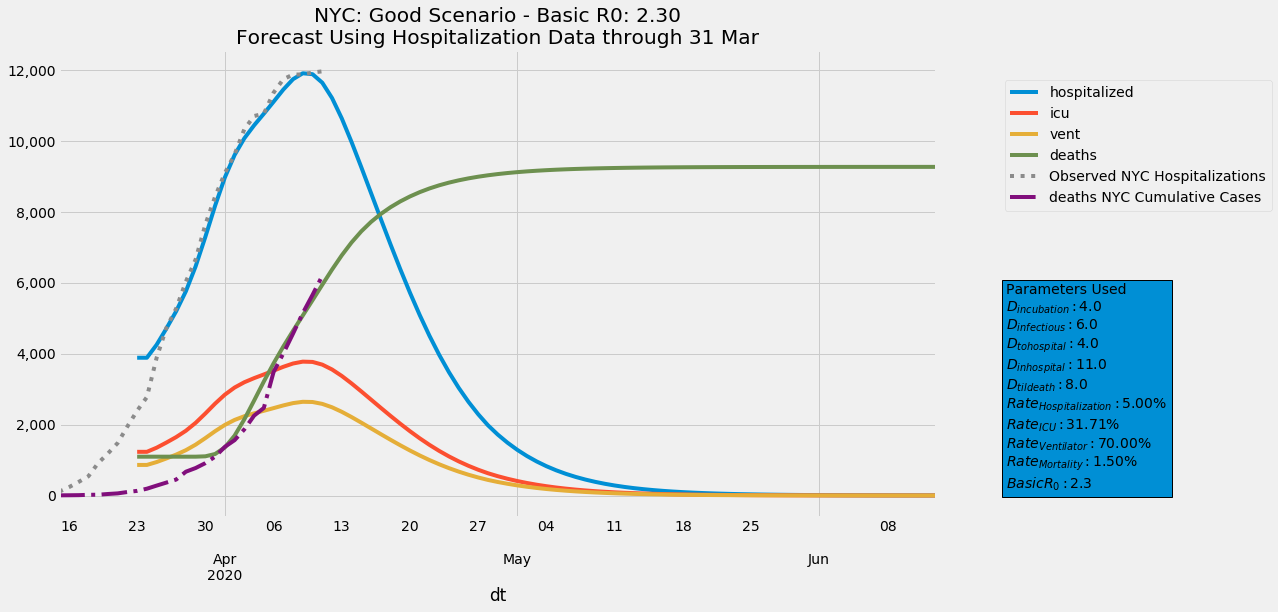

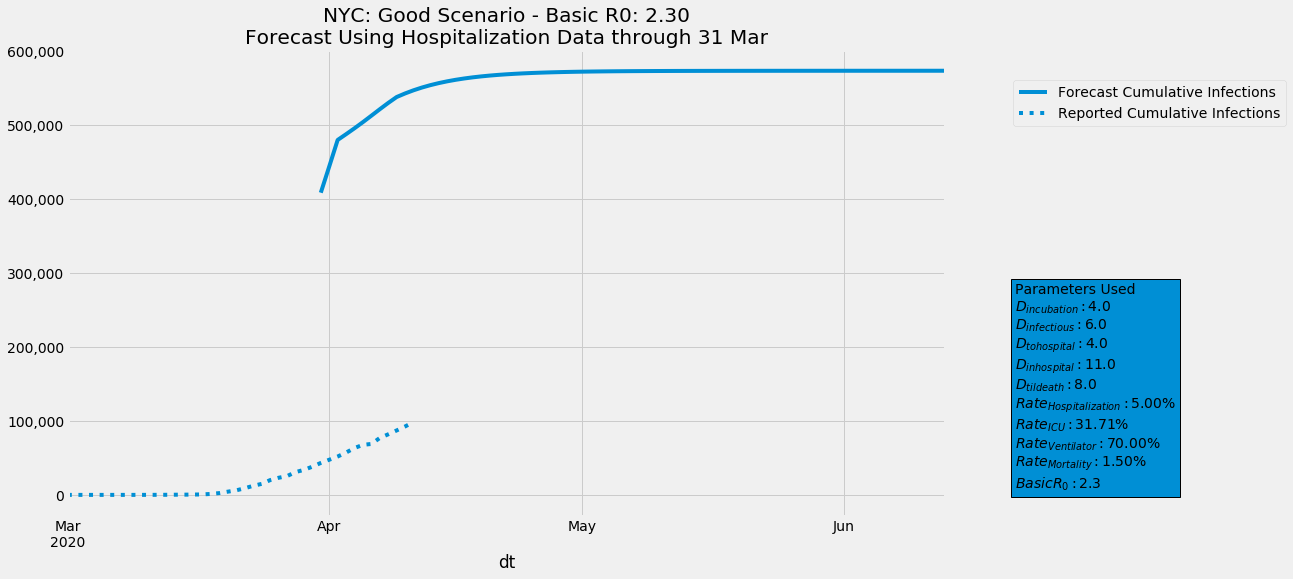

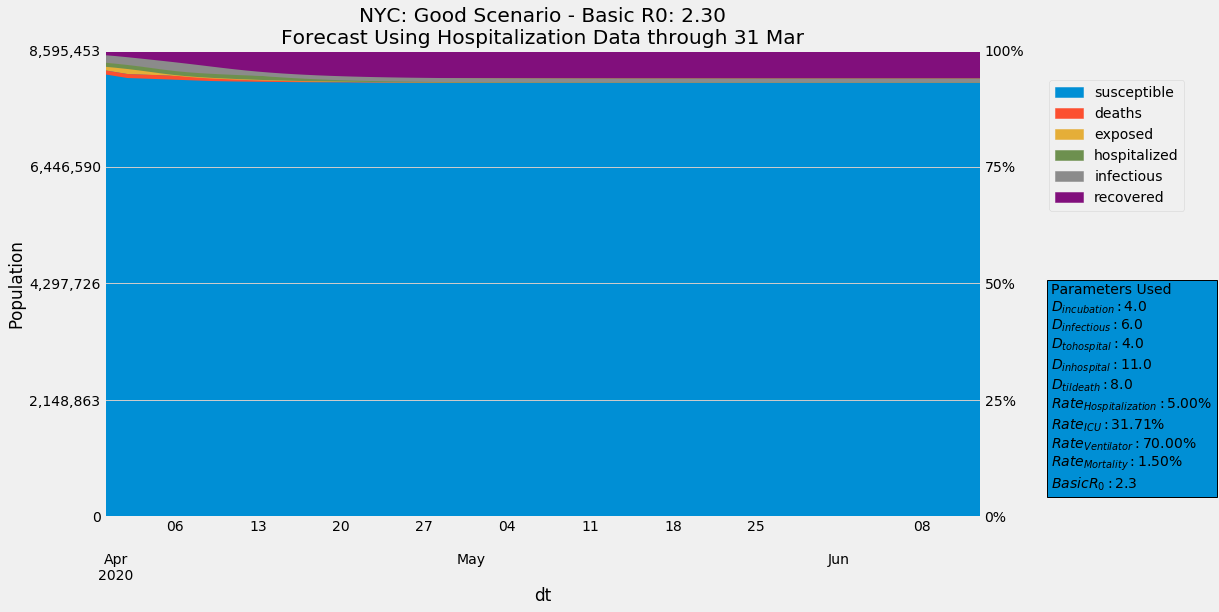

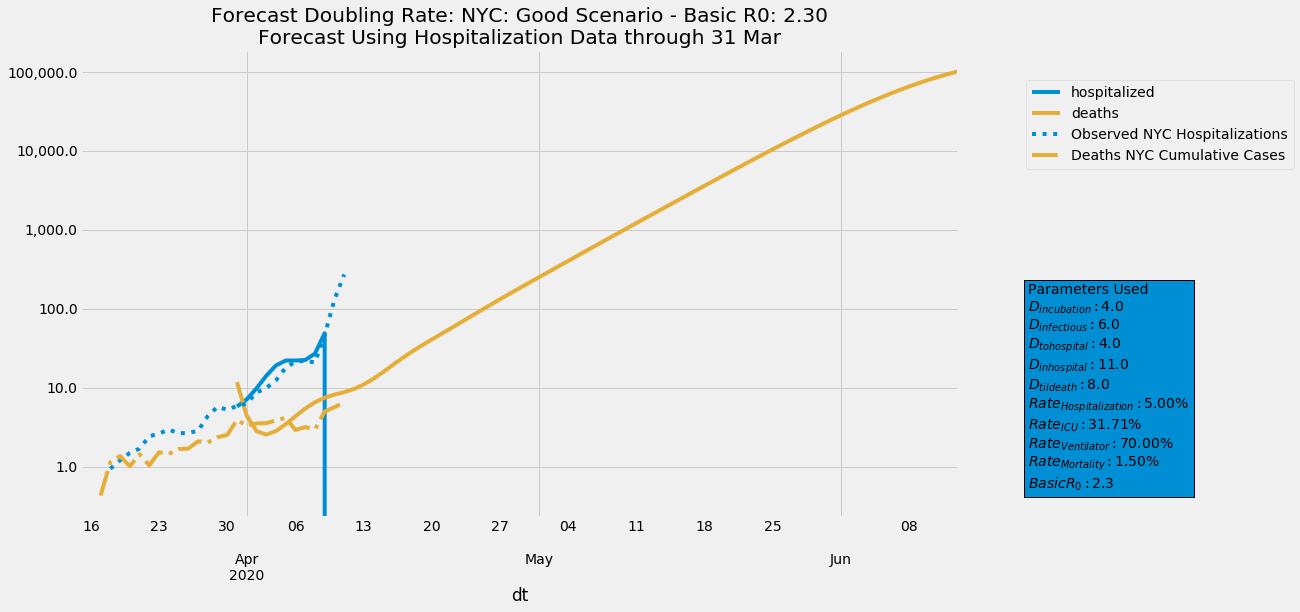

Peak Hospitalization Date:  09 Apr, 2020
Peak Hospitalization #: 11918
Peak ICU #: 3779
Peak Ventilator #: 2645


In [129]:
# Pre-intervention R0
basic_r0 = 2.3

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.7), ('2020-03-24', basic_r0*.15), 
           ('2020-03-31',basic_r0*.1), ('2021-05-15', basic_r0*.6)]

# Scenario Name
scenario_name = "Good"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


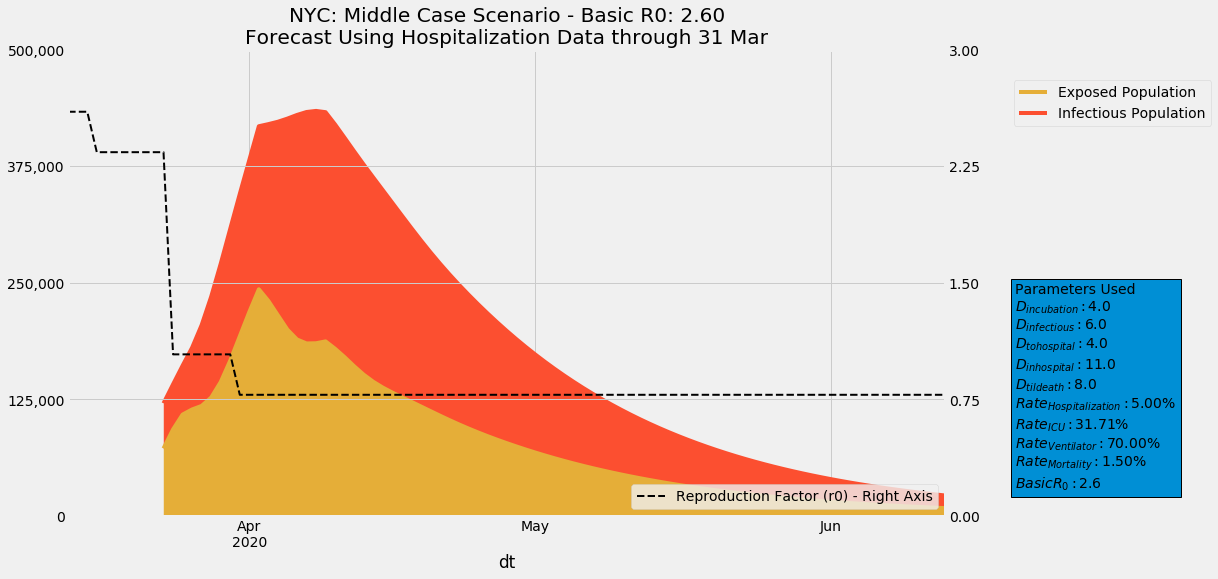

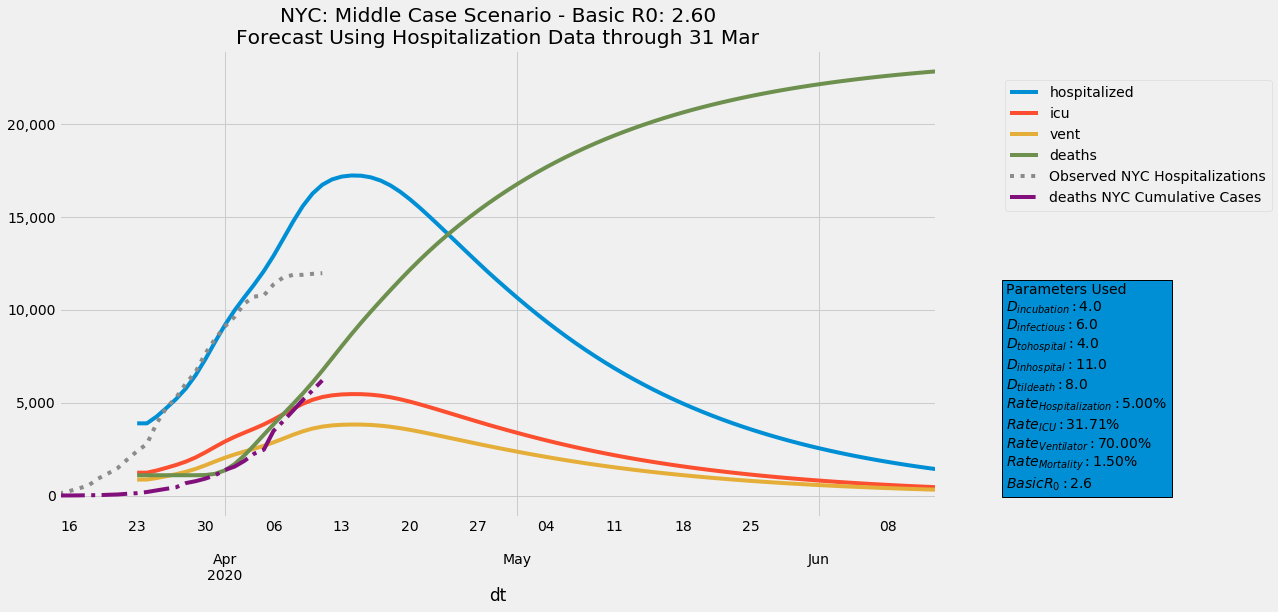

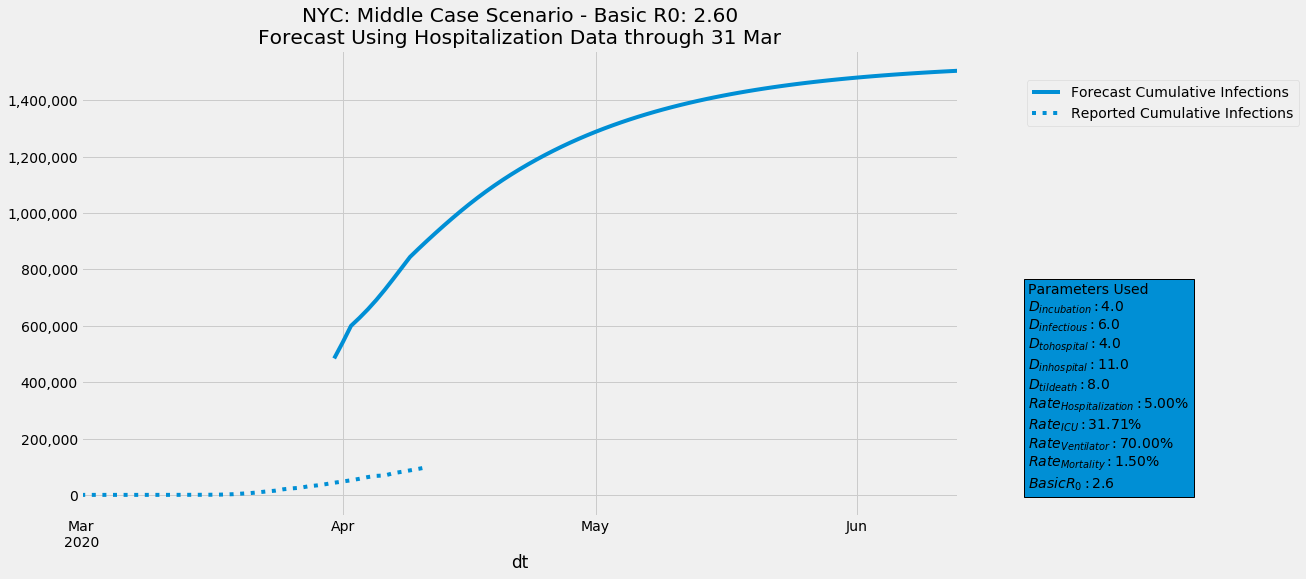

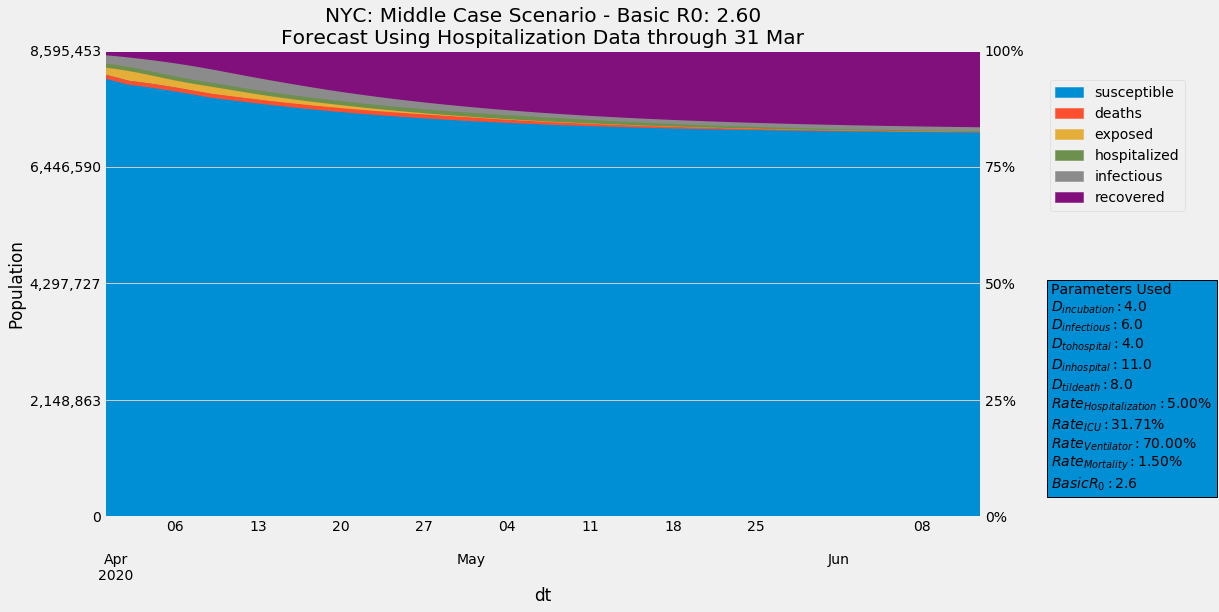

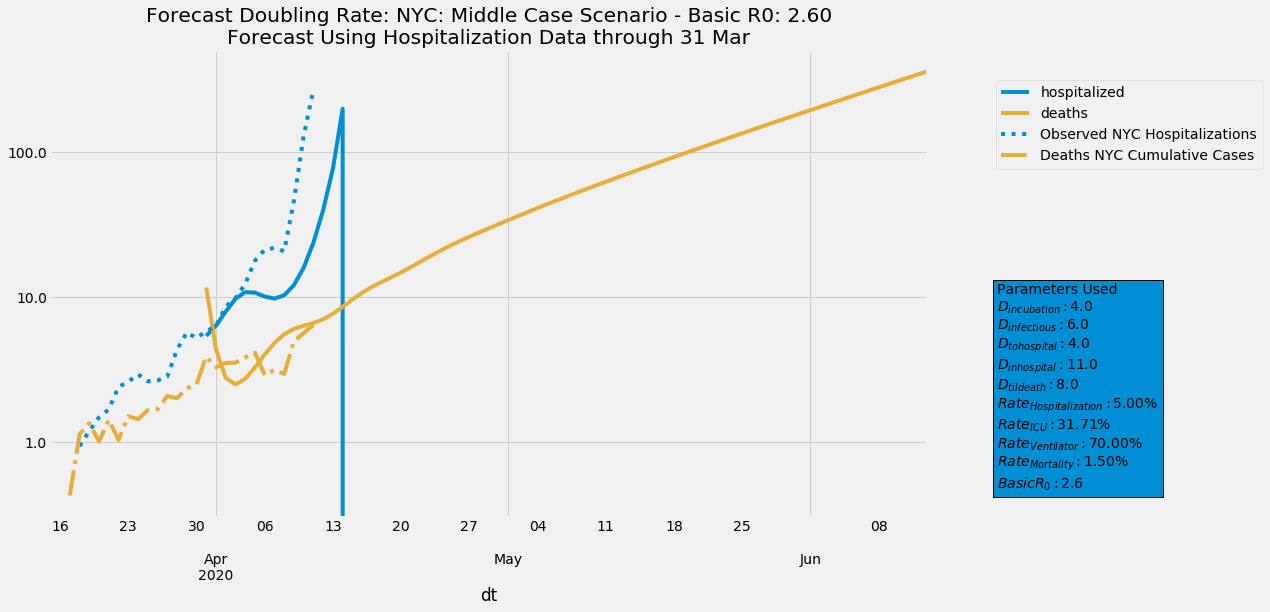

Peak Hospitalization Date:  14 Apr, 2020
Peak Hospitalization #: 17234
Peak ICU #: 5464
Peak Ventilator #: 3825


In [130]:
# Pre-intervention R0
basic_r0 = 2.6

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.4), 
           ('2020-03-31',basic_r0*.3), ('2021-05-15', basic_r0*.7)]

# Scenario Name
scenario_name = "Middle Case"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


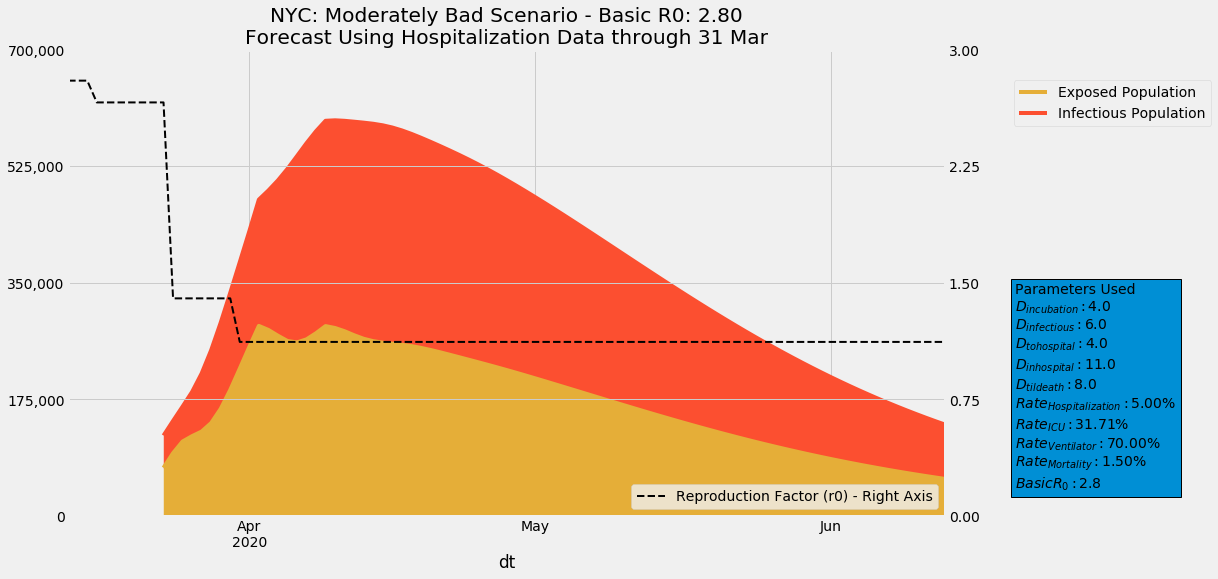

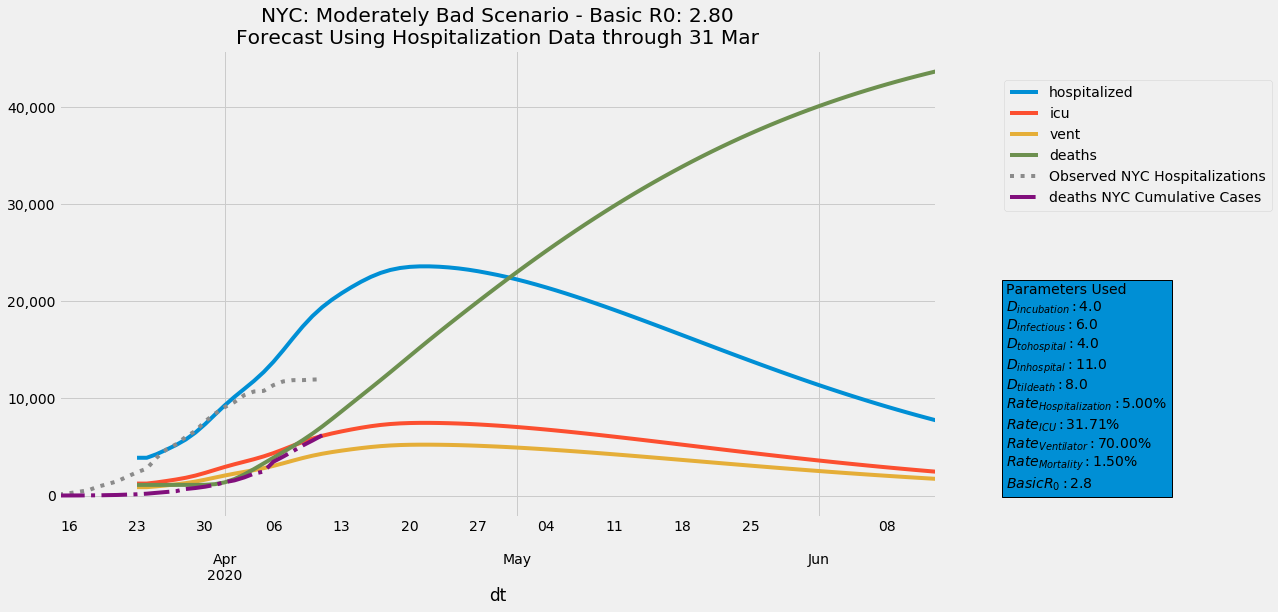

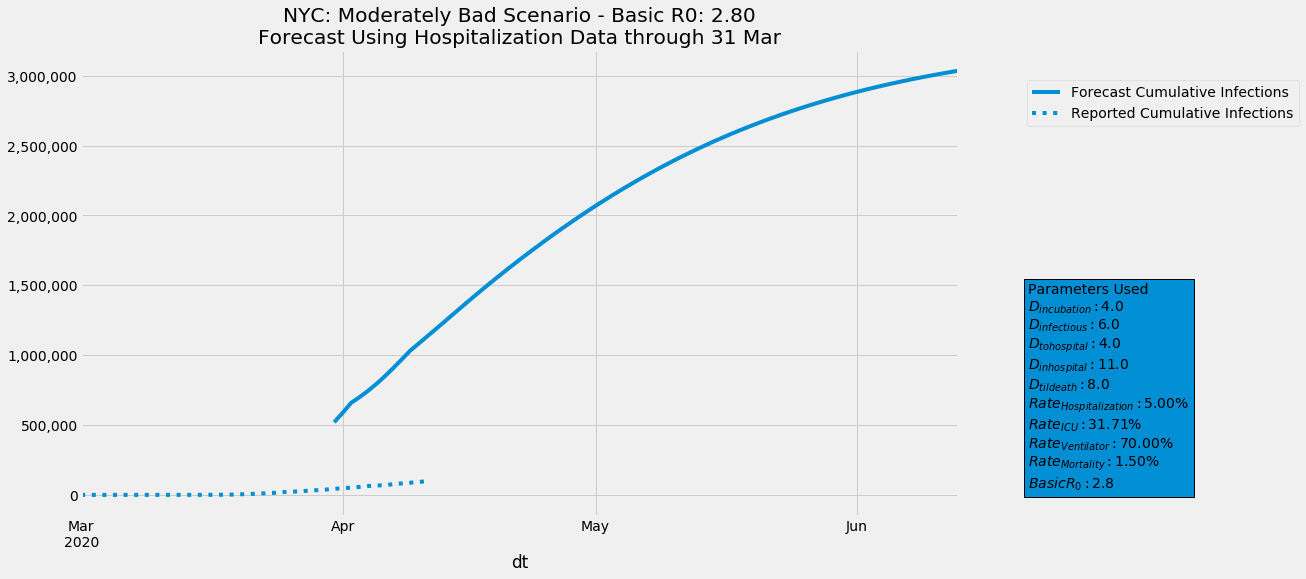

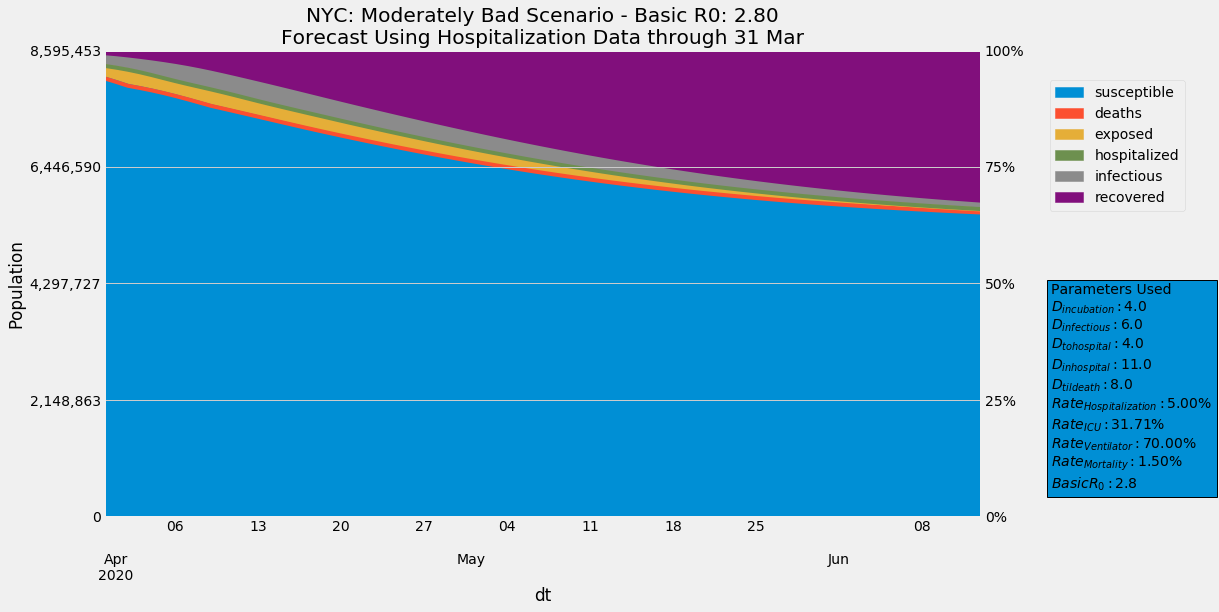

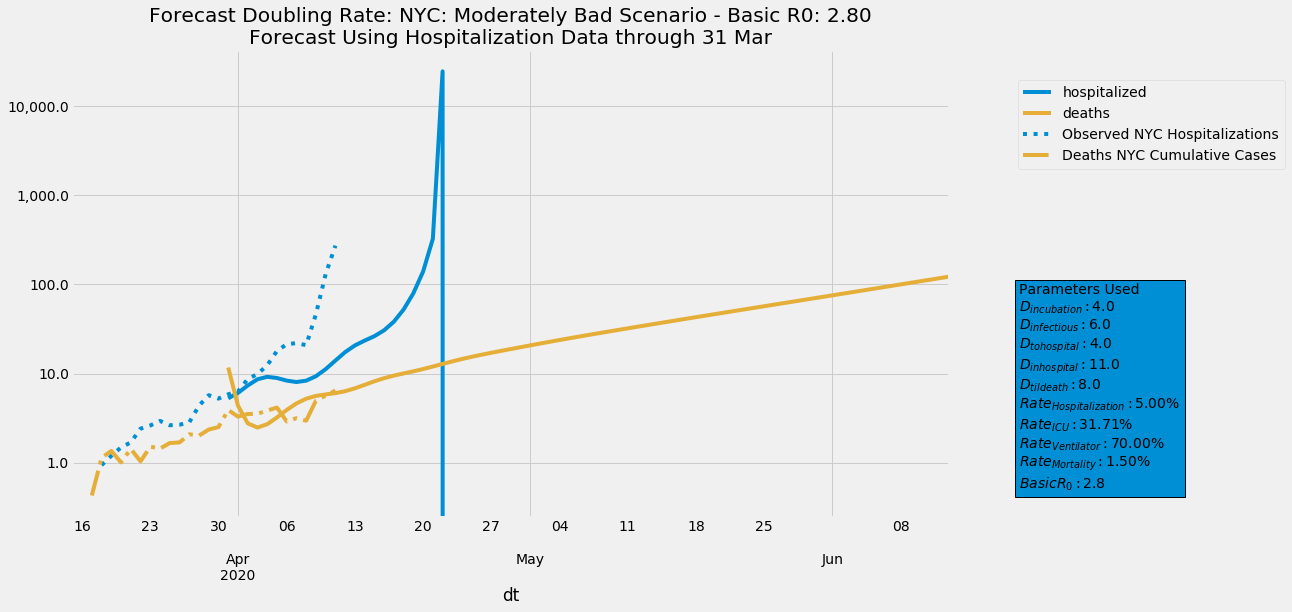

Peak Hospitalization Date:  22 Apr, 2020
Peak Hospitalization #: 23597
Peak ICU #: 7482
Peak Ventilator #: 5237


In [131]:
# Pre-intervention R0
basic_r0 = 2.8

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.95), ('2020-03-24', basic_r0*.5), 
           ('2020-03-31',basic_r0*.4), ('2021-05-15', basic_r0*.8)]

# Scenario Name
scenario_name = "Moderately Bad"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


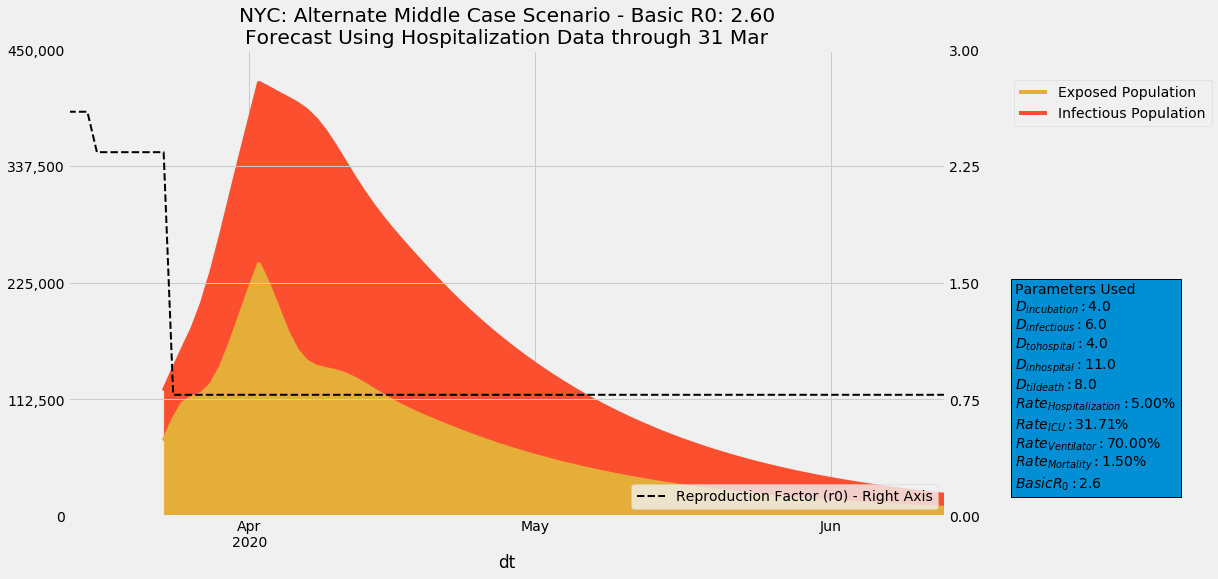

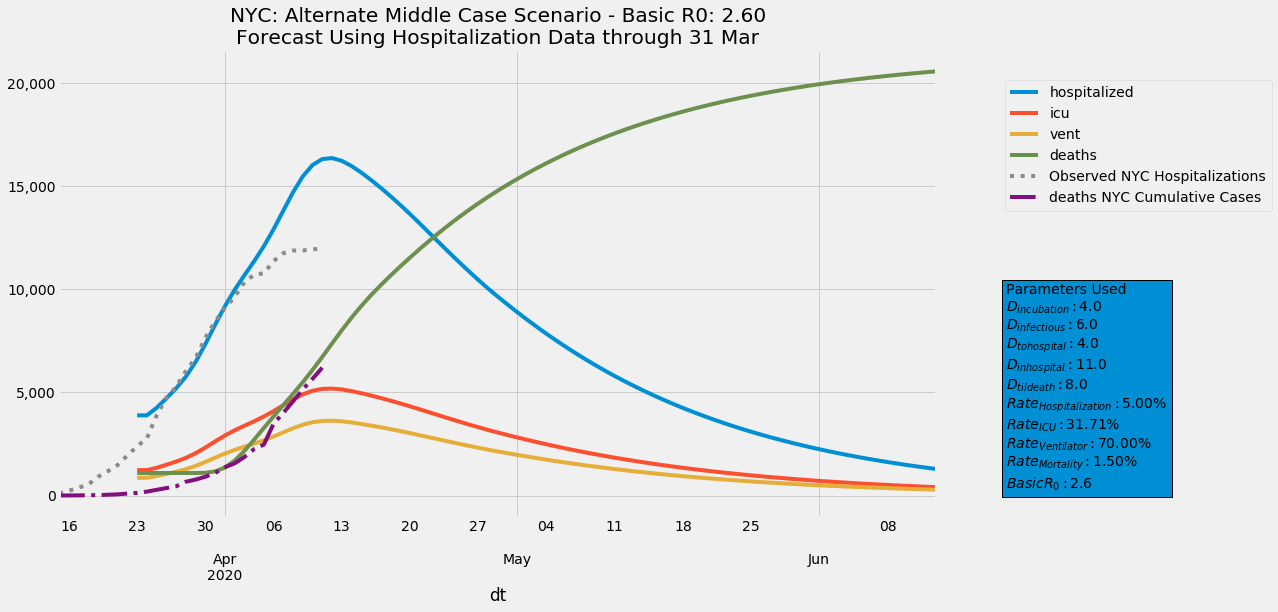

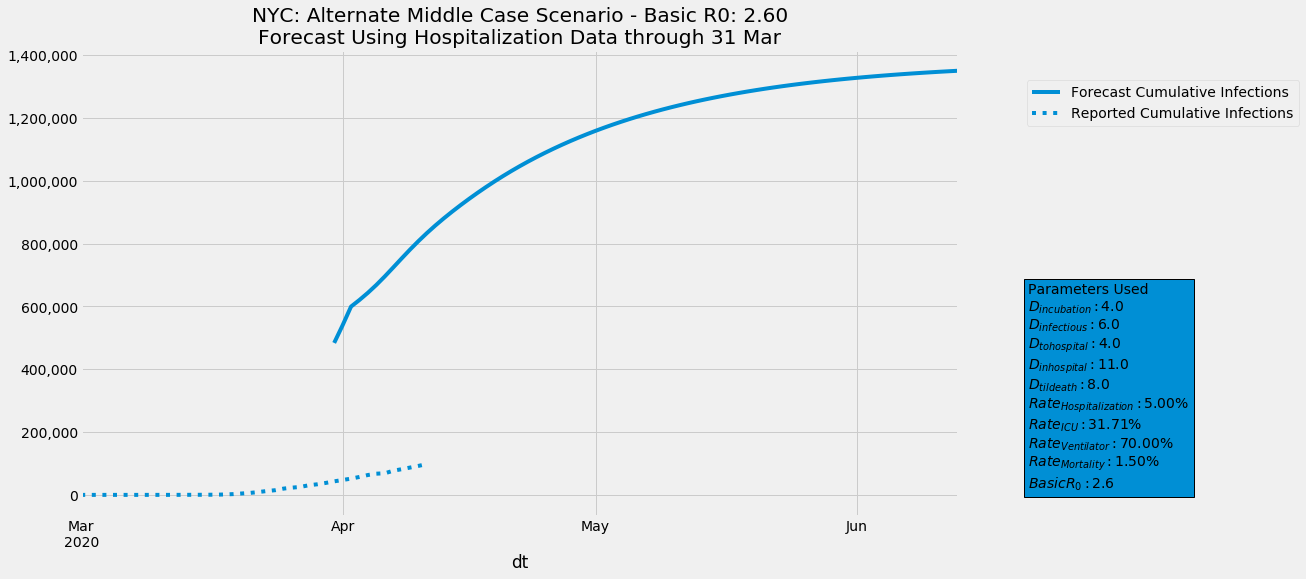

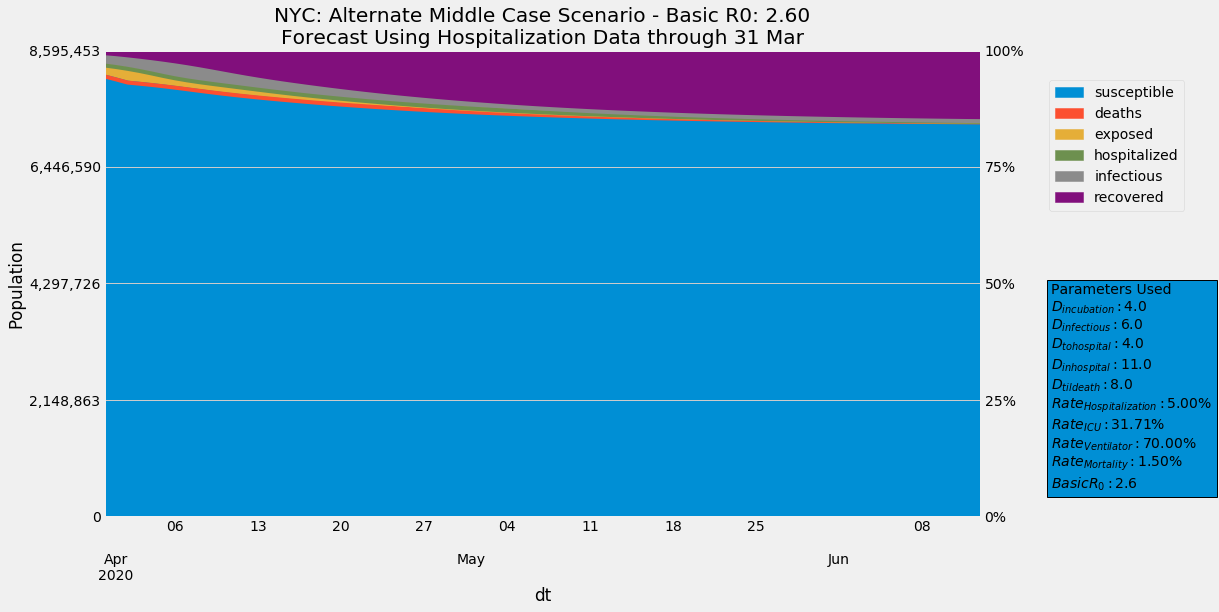

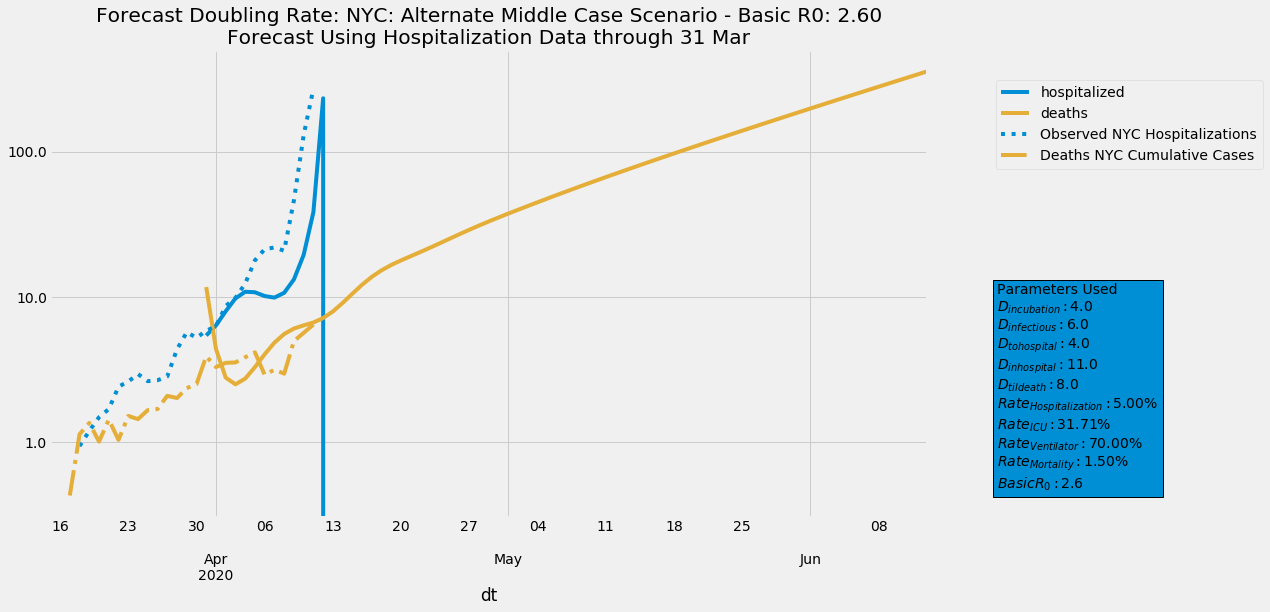

Peak Hospitalization Date:  12 Apr, 2020
Peak Hospitalization #: 16362
Peak ICU #: 5188
Peak Ventilator #: 3632


In [132]:
# Pre-intervention R0
basic_r0 = 2.6

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2021-05-15',basic_r0*.5)]

# Scenario Name
scenario_name = "Alternate Middle Case"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


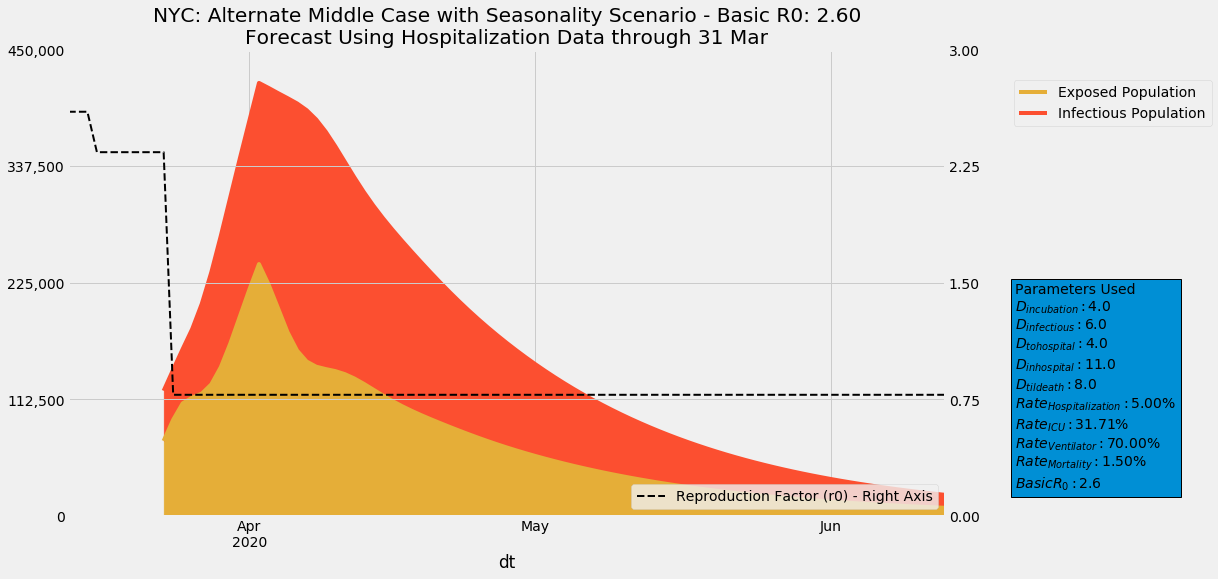

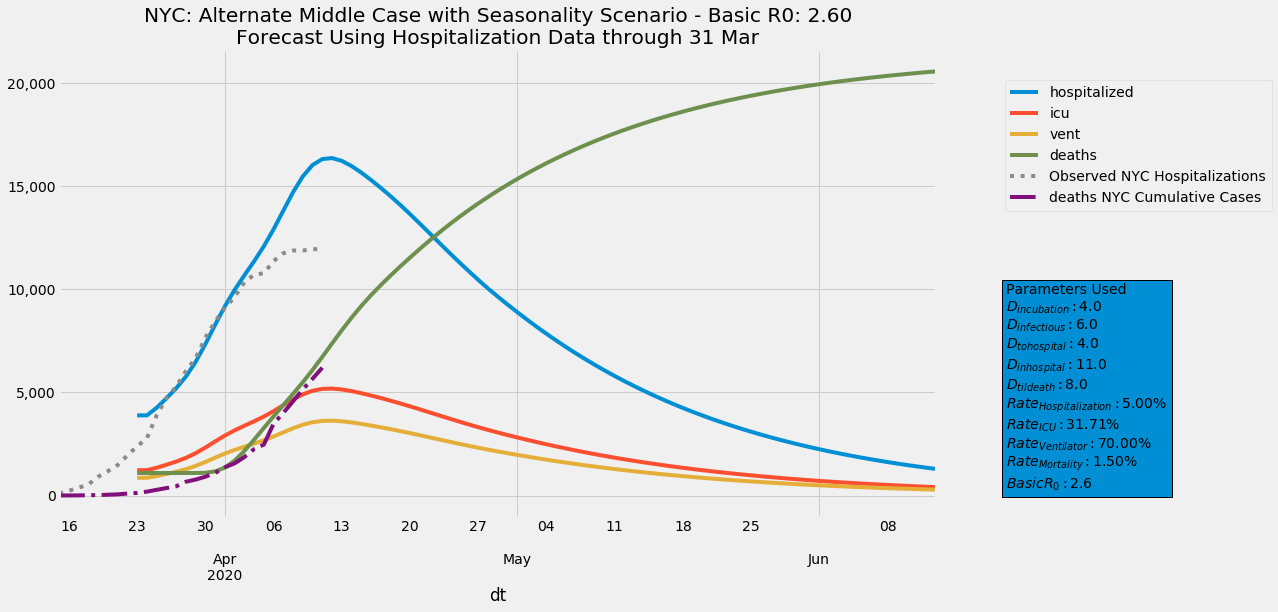

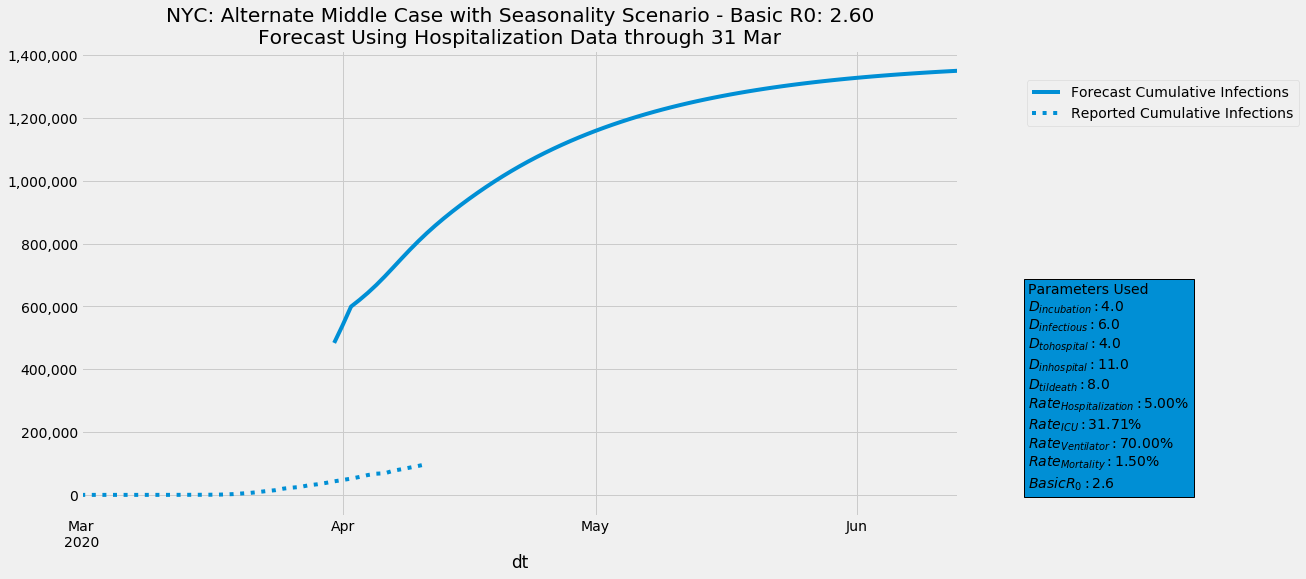

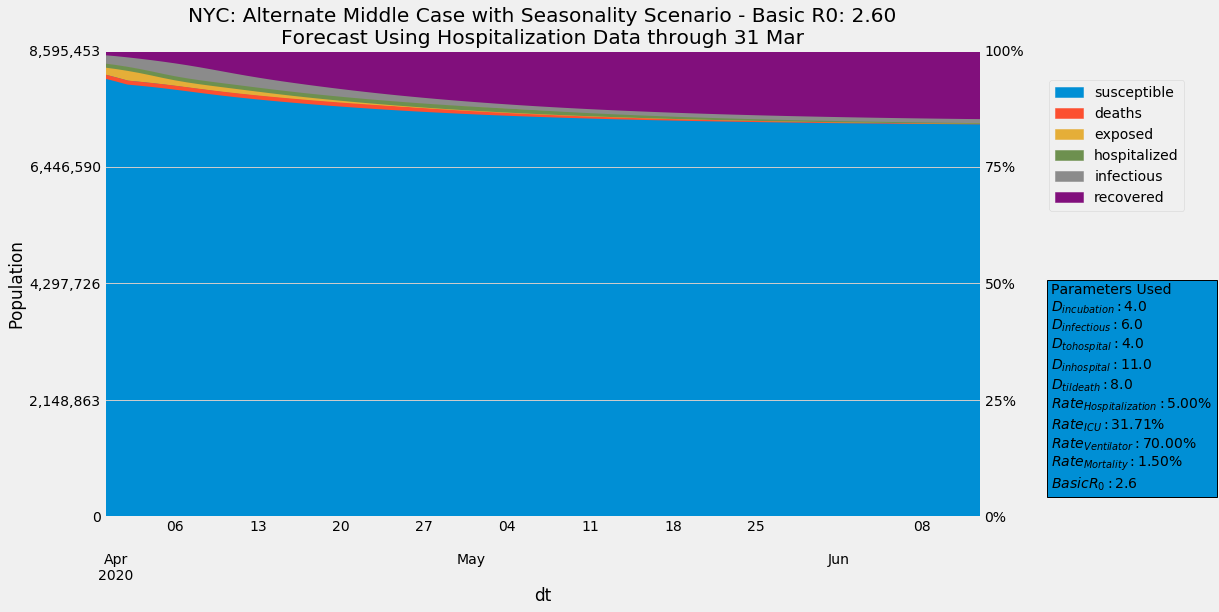

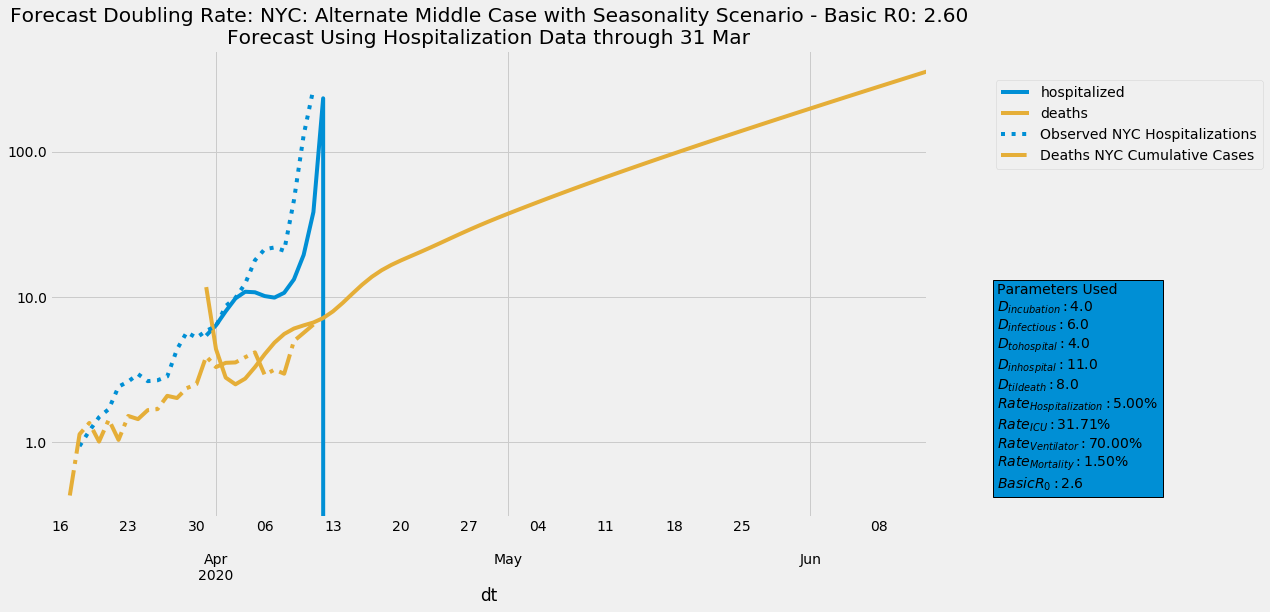

Peak Hospitalization Date:  12 Apr, 2020
Peak Hospitalization #: 16362
Peak ICU #: 5188
Peak Ventilator #: 3632


In [133]:
# Pre-intervention R0
basic_r0 = 2.6

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.

r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2021-05-15',basic_r0*.5*.8),
           ('2020-09-01', basic_r0*.5)]

# Scenario Name
scenario_name = "Alternate Middle Case with Seasonality"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, curr_exposed, curr_infectious, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


## Scenario Parameter Space Exploration

In [58]:
chart_col_dict = {'Citymapper Data Adjusted Reproduction Factor':'Activity Data-Based Forecast',
 'Good':'Optimistic Case', 'Middle Case':'Delayed-Effect Middle Case', 'Moderately Bad':'Bad Case',
       'Alternate Middle Case':'Middle Case'}

In [59]:
scenario_dict = {}

In [60]:
# ############# MODEL PARAMETERS #################
# # Total Population
# total_pop = 8e6 #19.6e6 #8e6 

# # Name of Region
# region_name = "NYC"

# hosp_obs_dt = pd.Timestamp('2020-03-31')#pd.Timestamp('2020-03-25')

# # Current Hospitalizations
# curr_hosp = df_hosps[region_name].loc[hosp_obs_dt]

# # Proportion of Total Infected/Exposed Population that is Exposed (i.e. not yet infectious)
# exposed_pct = .5 #.2

# # Total # of cases currently recovered/immune
# curr_recovered = 2000.

# # Number of days to forecast
# d_to_forecast = 200 #60

# # Days from exposure until symptoms (i.e. incubation period)
# d_incub=5.1 #4

# # Days after incubation period when infectious
# d_infect=5.

# # Mortality Rate
# mort_rt=.008

# # Average number of days in hospital for a hospitalized case
# d_in_hosp=14.

# # Hospitalization Rate of all infected people
# hosp_rt=.08

# # Days from end of incubation period until death for patients who die
# d_til_death=12.

# # Days from incubation period til arrival in hospital for all hospitalizations
# d_to_hosp=7. #11. #3. #7.

# # ICU rate as a proportion of all hospitalizations.
# icu_rt = 13./41. #Lancet Study Estimate
 
# # Ventilator rate as a proportion of all hospitalizations
# vent_rt = .7

# # [Currently not functional] Days in hospital for mild hospitalizations
# d_in_hosp_mild= 11. #NEJM Study Estimate

# # [Currently not functional] Days in hospital for ICU hospitalizations
# d_in_icu = 13. #NEJM Study Estimate

# # 8 Days Before Hospitalization Data, 
# # last_obs_dt = (hosp_obs_dt - pd.Timedelta(days=((d_incub+d_to_hosp)*1.))).round(freq='d')
# # print('implied last obs dt:', last_obs_dt)

# # Total # of deaths
# curr_deaths = df_reporting_fmt['deaths'][region_name].loc[hosp_obs_dt]

# # Susceptible Population
# curr_suspop = total_pop - curr_hosp/hosp_rt - curr_recovered - curr_deaths
# print('curr hosp obs dt: ', hosp_obs_dt)
# print('curr_hosp: ',curr_hosp)
# print('curr_deaths: ',curr_deaths)




# df_scenarios = pd.DataFrame()

# l_d_to_hosp = [3., 7., 11.]
# if len(l_d_to_hosp) > 1:
#     d_to_hosp = (min(l_d_to_hosp), max(l_d_to_hosp))
# else:
#     d_to_hosp = l_d_to_hosp[0]
    
# l_basic_r0 = [2.0, 3.0, 4.0, 5.0]
# if len(l_basic_r0) > 1:
#     basic_r0 = (min(l_basic_r0), max(l_basic_r0))
# else:
#     basic_r0 = l_basic_r0[0]
    
# param_str = param_str_maker(d_incub, d_infect, d_to_hosp, d_in_hosp, d_til_death,
#                 hosp_rt, icu_rt, vent_rt, mort_rt, basic_r0)

# for basic_r0 in l_basic_r0:
# #     entropy_rep_factor = 0.85
# #     entropy_lag_factor = int(d_incub+d_infect)

# #     adj_df_entropy = df_entropy.diff().mul(entropy_rep_factor).cumsum().add(
# #         df_entropy.iloc[0]).fillna(df_entropy.iloc[0])
# #     adj_df_entropy = adj_df_entropy.reindex(
# #         pd.date_range(adj_df_entropy.index[0],
# #                       adj_df_entropy.index[-1]+pd.Timedelta(days=entropy_lag_factor) ) )
# #     adj_df_entropy = adj_df_entropy.shift(entropy_lag_factor).fillna(method='bfill').clip(lower=0.01)
# # #     ax = adj_df_entropy['entropy_pct'].plot(label='adjusted movement', legend=True)
# # #     df_entropy['entropy_pct'].plot(ax = ax, label='movement', legend=True)
# # #     _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# # #     plt.show()

# #     # Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# #     # The second element is the r0 value for that policy action. Policy actions should be separated by
# #     # a comma.
# #     r_dates = list(adj_df_entropy.mul(basic_r0).itertuples(index=True))

# #     # Scenario Name
# #     scenario_name = 'Activity Data-Based Forecast'
# #     scenario_dict[scenario_name] = r_dates
#     # scenario_dict["Full Wuhan-Style Lockdown"] = [('2020-03-16', basic_r0*.9), ('2020-03-24', 0.33), ('2020-05-15',basic_r0*.75)]
#     scenario_dict['Optimistic Case'] = [('2020-03-16', basic_r0*.85), ('2020-03-24', basic_r0*.3), 
#                ('2020-03-31',basic_r0*.2), ('2020-05-15', basic_r0*.6)]
#     scenario_dict['Delayed-Effect Middle Case'] = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.4), 
#                ('2020-03-31',basic_r0*.3), ('2020-05-15', basic_r0*.7)]
#     scenario_dict['Moderately Bad Case'] = [('2020-03-16', basic_r0*.95), ('2020-03-24', basic_r0*.5), 
#                ('2020-03-31',basic_r0*.4), ('2020-05-15', basic_r0*.8)]
#     scenario_dict['Middle Case'] = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2020-05-15',basic_r0*.5)]
#     scenario_dict["Middle Case with Seasonality"] = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2020-05-15',basic_r0*.5*.8),
#                ('2020-09-01', basic_r0*.5)]
#     for d_to_hosp in l_d_to_hosp:
#         for scenario_name, r_dates in scenario_dict.items():
#             print(scenario_name, r_dates[0])
#             curr_exposed = curr_hosp/hosp_rt*exposed_pct
#             curr_infectious = curr_hosp/hosp_rt*(1-exposed_pct)
#             r_t = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp)), 
#                                                         hosp_obs_dt + pd.Timedelta(days=d_to_forecast)))
#             pa_s = pd.DataFrame(r_dates)
#             pa_s = pa_s.set_index(pa_s.columns[0])[pa_s.columns[1]]
#             pa_s.index = pd.to_datetime(pa_s.index).normalize()
#             r_t.index = pd.DatetimeIndex(r_t.index).normalize()
#             r_t = r_t.fillna(pa_s)
#             if pd.isnull(r_t.iloc[0]):
#                 r_t.iloc[0] = basic_r0
#             r_t = r_t.fillna(method='ffill')
#             l_r_t = r_t.to_list()

#             df_agg, df_all_cohorts = seir_model_cohort(
#                 curr_suspop, curr_exposed, curr_infectious, 
#                 df_hosps[region_name][hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp))],
#                 curr_recovered, curr_deaths, hosp_obs_dt,
#                 l_r_t, d_incub, d_infect, d_to_forecast, mort_rt, d_in_hosp, 
#                 hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
#                 icu_rt, d_in_icu, vent_rt
#             ) 
#             df_scenarios[scenario_name+'_d2h'+str(int(d_to_hosp))+'_r0'+str(int(basic_r0)) ] = df_agg.stack()

In [61]:
# df_chart_all = df_scenarios.unstack().swaplevel(axis=1)
# for col in df_chart_all.columns.levels[0]:

#     df_chart = df_chart_all[col]
#     df_chart = df_chart.iloc[8:]

#     chart_title = "{0} {2} Scenarios\nForecast Using Hospitalization Data through {1}".format(
#             region_name, hosp_obs_dt.strftime("%d %b"), col.capitalize())

#     ax = df_chart.mean(axis=1).plot(label='Mean', legend=True)
#     ax = df_chart.median(axis=1).plot(label='Median', legend=True)

#     if col == 'hospitalized':
#         _ = df_hosps[region_name].plot(ax=ax, label='Reported Hospitalizations',
#                                       color='black', linestyle=':', legend=True)
#         plt.legend(['Mean of Forecasts','Median of Forecasts','Reported Hospitalizations'])
#     else:
#         plt.legend(['Mean of Forecasts','Median of Forecasts','Reported Hospitalizations'])
        
#     df_chart.plot(ax=ax, figsize=[14,8], title=chart_title, legend=False, 
#                        label=['_nolegend_']*72, alpha=.1)

#     _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    

#     ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
#         verticalalignment='bottom', bbox={'ec':'black','lw':1})
#     plt.show()

In [62]:
# ax =df_hosps[region_name].dropna().plot(figsize=[14,8], color='black', linestyle=':',
#                                title='{} Reported Hospitalizations'.format(region_name))

# print(df_hosps[region_name].diff().rolling(4).mean().iloc[[-1]])
# _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Explain Cohort Model

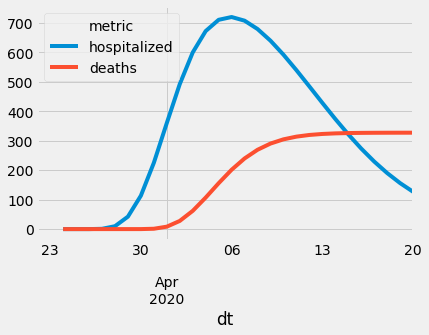

In [63]:
df_all_cohorts.iloc[:,2].unstack(1)[['hospitalized','deaths']].iloc[:30].plot()

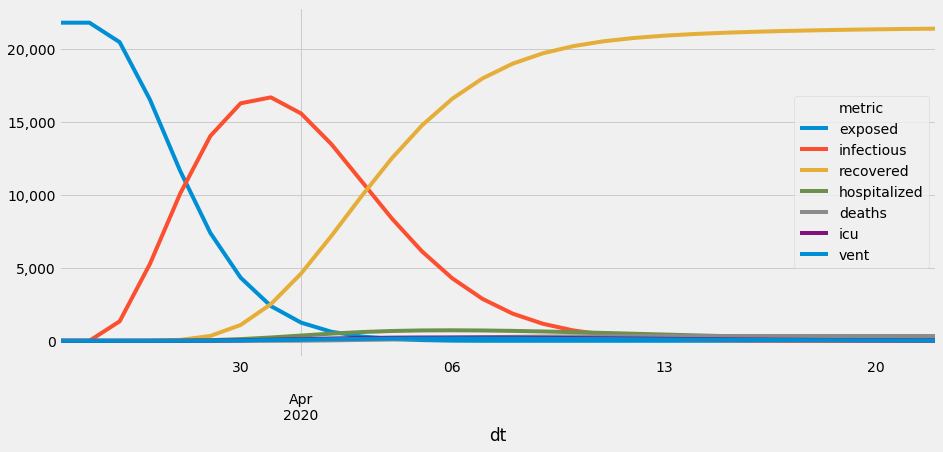

In [64]:
ax = df_all_cohorts.iloc[:,2].unstack().dropna().iloc[:30].plot(figsize=[14,6])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


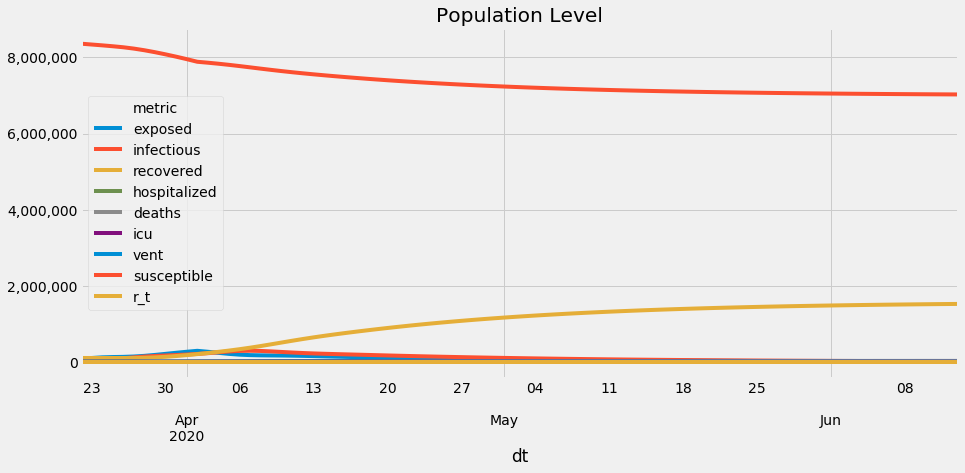

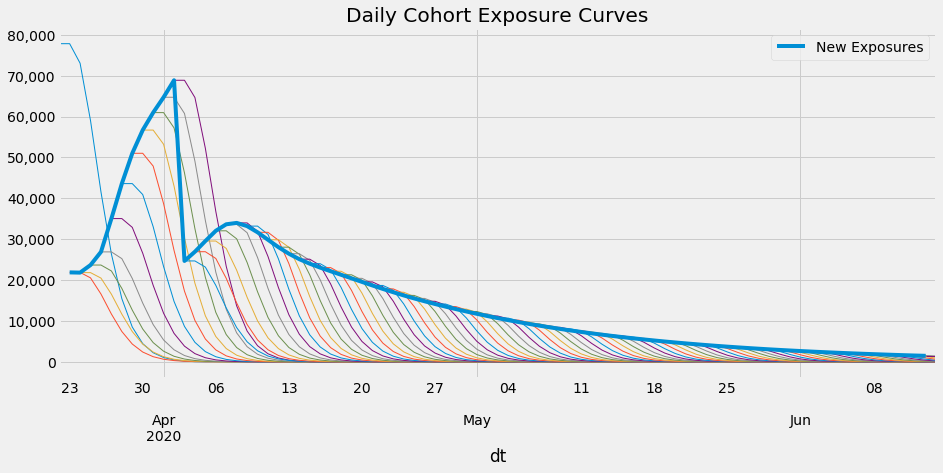

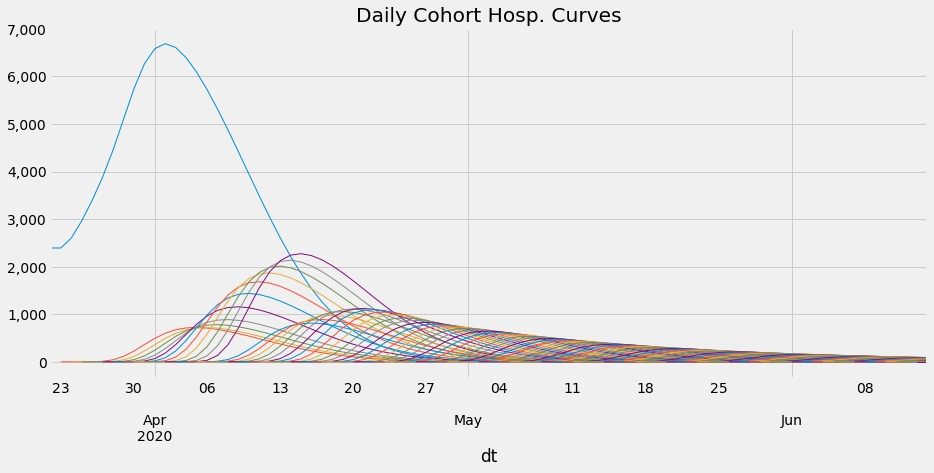

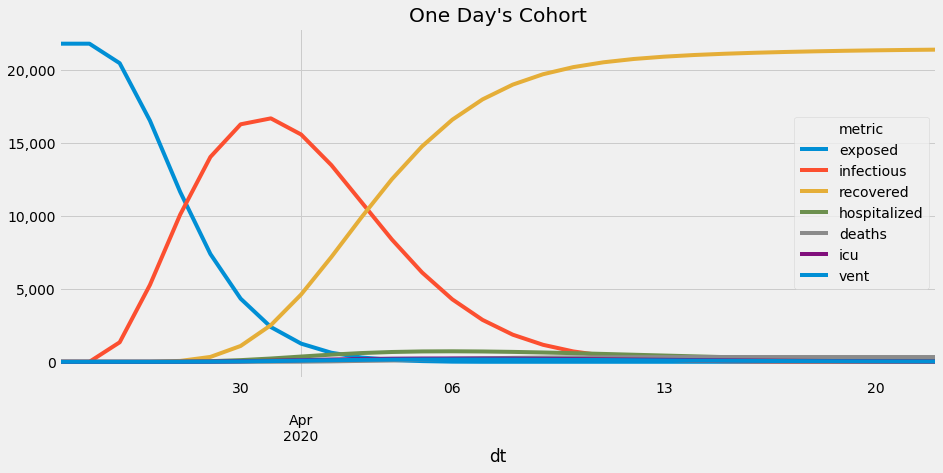

In [65]:
ax = df_agg.plot(label='Susceptible Population', legend=True,figsize=[14,6], title='Population Level')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

ax = df_all_cohorts.unstack().swaplevel(axis=1)['exposed'].plot(legend=False, figsize=[14,6], 
                                                          linewidth=1, title='Daily Cohort Exposure Curves')
df_agg.susceptible.diff().mul(-1).plot(ax=ax, label='New Exposures', legend=True)
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

ax = df_all_cohorts.unstack().swaplevel(axis=1)['hospitalized'].plot(legend=False, figsize=[14,6], 
                                                          linewidth=1, title='Daily Cohort Hosp. Curves')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

ax = df_all_cohorts.iloc[:,2].unstack().dropna().iloc[:30].plot(figsize=[14,6], title='One Day\'s Cohort')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()
